In [1]:
import matplotlib.pyplot as plt
import torch
import os
from pathlib import Path
from importlib import reload

os.chdir("..")  # Change root dir to project folder
os.getcwd()

'/home/bbd0953/diffusion/src'

# Random Experiments

In [2]:
tags_file = Path(
    '/home/bbd0953/diffusion/image_data/LOFAR/tags-v1.1.json'
)

# Read dict
import json
with open(tags_file, 'r') as f:
    tags = json.load(f)

In [15]:
len(tags)

10719

In [6]:
# Dict values are lists of strings. List all unique strings
# along with their counts
from collections import Counter

tag_counts = Counter()

for tag_list in tags.values():
    tag_counts.update(tag_list)

# Sort by count
tag_counts = dict(sorted(tag_counts.items(), key=lambda x: x[1], reverse=True))

# Print list of all tags
for tag, count in tag_counts.items():
    print(tag, count)

solid-ellipse 3216
core-jet 2015
doublelobe 2013
compact 1564
triple 1304
diffuse 1234
compacts 1148
hourglass 992
submitted 448
hybrid 421
blend 397
core-jets 397
nat 372
bent 342
wat 316
sdragn 299
too-zoomed-in 290
extended 288
galaxy 281
clumpy 247
overedge 235
no_clear_source 212
no-optical-source 201
stretched-compact 200
possible_jets 198
double 191
toozoomedin 183
restarted 176
no-dashed-ellipses 158
stretched 136
one-sided 122
ddrg 121
x-shaped 112
disk 102
jets 96
galaxycluster 92
complex 89
interesting 87
diffuseradiosources 84
s-shaped 77
corejet 73
artefact 71
dashed-ellipses 68
noise 64
cluster 62
orc 62
tail 62
unusual 61
v-shaped 59
spiral 58
doublelobes 58
nascent-doublelobe 58
hybrid-doublelobe 56
double-lobe 54
difficult 54
star 53
hybrid-feature 52
furtherresearch 50
overlapping 47
diffuse-clumpy 46
badpicture 41
galaxies 41
star-forming-galaxy 39
quasar 39
nascent-hourglass 37
nascent 35
ring 34
diffuse-core-jet 34
precessing-compact 33
image-missing 33
host-galaxy

In [21]:
# Search source by tag, i.e. for a given tag, return all source names (keys)
# that have this tag in their list
def search_sources_by_tag(tag, tags=tags):
    return [source for source, tag_list in tags.items() if tag in tag_list]

# Example
search_result = search_sources_by_tag('core-jet')

len(search_result)

2015

In [11]:
import utils.paths as paths
import data.datasets as datasets

reload(datasets)
from data.datasets import LOFARPrototypesDataset

proto_dset = LOFARPrototypesDataset(
    paths.LOFAR_SUBSETS["prototypes"],
    img_size=80,
    train_mode=True,
    attributes=[],
)

INFO (data.datasets): Loading images...
INFO (data.datasets): Loading names from catalog...
INFO (data.datasets): Data set initialized.
INFO (data.datasets): Loading mask metadata...
INFO (data.datasets): Image size 80: Removing sources with model_radius > 40.0...
INFO (data.datasets): Removed 571 of 23_817 sources (2.4%).
INFO (data.datasets): Reshaping images...
INFO (data.datasets): Attribute 'mask_sizes' transformed with Box-Cox transformation ([-0.59550309]).


In [12]:
# Look at intersection and set differences between tag dictionary and dataset
# sources
tag_keys = set(tags.keys())
dset_keys = set(proto_dset.names)

not_in_dset = tag_keys - dset_keys
not_in_tags = dset_keys - tag_keys
intersection = tag_keys & dset_keys

print(f"Sources in prototypes dataset but not in tags: {len(not_in_tags)}")
print(f"Sources in tags but not in prototypes dataset: {len(not_in_dset)}")
print(f"Intersection: {len(intersection)}")

Sources in dataset but not in tags: 22663
Sources in tags but not in dataset: 10136
Intersection: 583


In [13]:
import data.datasets as datasets

reload(datasets)
from data.datasets import LOFARDataset

lofar_dset = LOFARDataset(
    paths.LOFAR_SUBSETS["200p"],
    img_size=200,
    train_mode=False,
    attributes=["masks_edge_thr"],
)

lofar_dset.masks = lofar_dset.masks_edge_thr

INFO (data.datasets): Loading images...
INFO (data.datasets): Loading names from catalog...
INFO (data.datasets): Loading 'masks_edge_thr'...
INFO (data.datasets): Data set initialized.


In [14]:
# Look at intersection and set differences between tag dictionary and dataset
# sources
tag_keys = set(tags.keys())
dset_keys = set(lofar_dset.names)

not_in_dset = tag_keys - dset_keys
not_in_tags = dset_keys - tag_keys
intersection = tag_keys & dset_keys

print(f"Sources in LOFAR dataset but not in tags: {len(not_in_tags)}")
print(f"Sources in tags but not in LOFAR dataset: {len(not_in_dset)}")
print(f"Intersection: {len(intersection)}")

Sources in LOFAR dataset but not in tags: 124975
Sources in tags but not in LOFAR dataset: 8135
Intersection: 2584


In [18]:
# Reduce tags to only those that are present in the LOFAR dataset
tags_lofar = {k: tags[k] for k in intersection}
idxs_lofar = {k: i for i, k in enumerate(lofar_dset.names)}

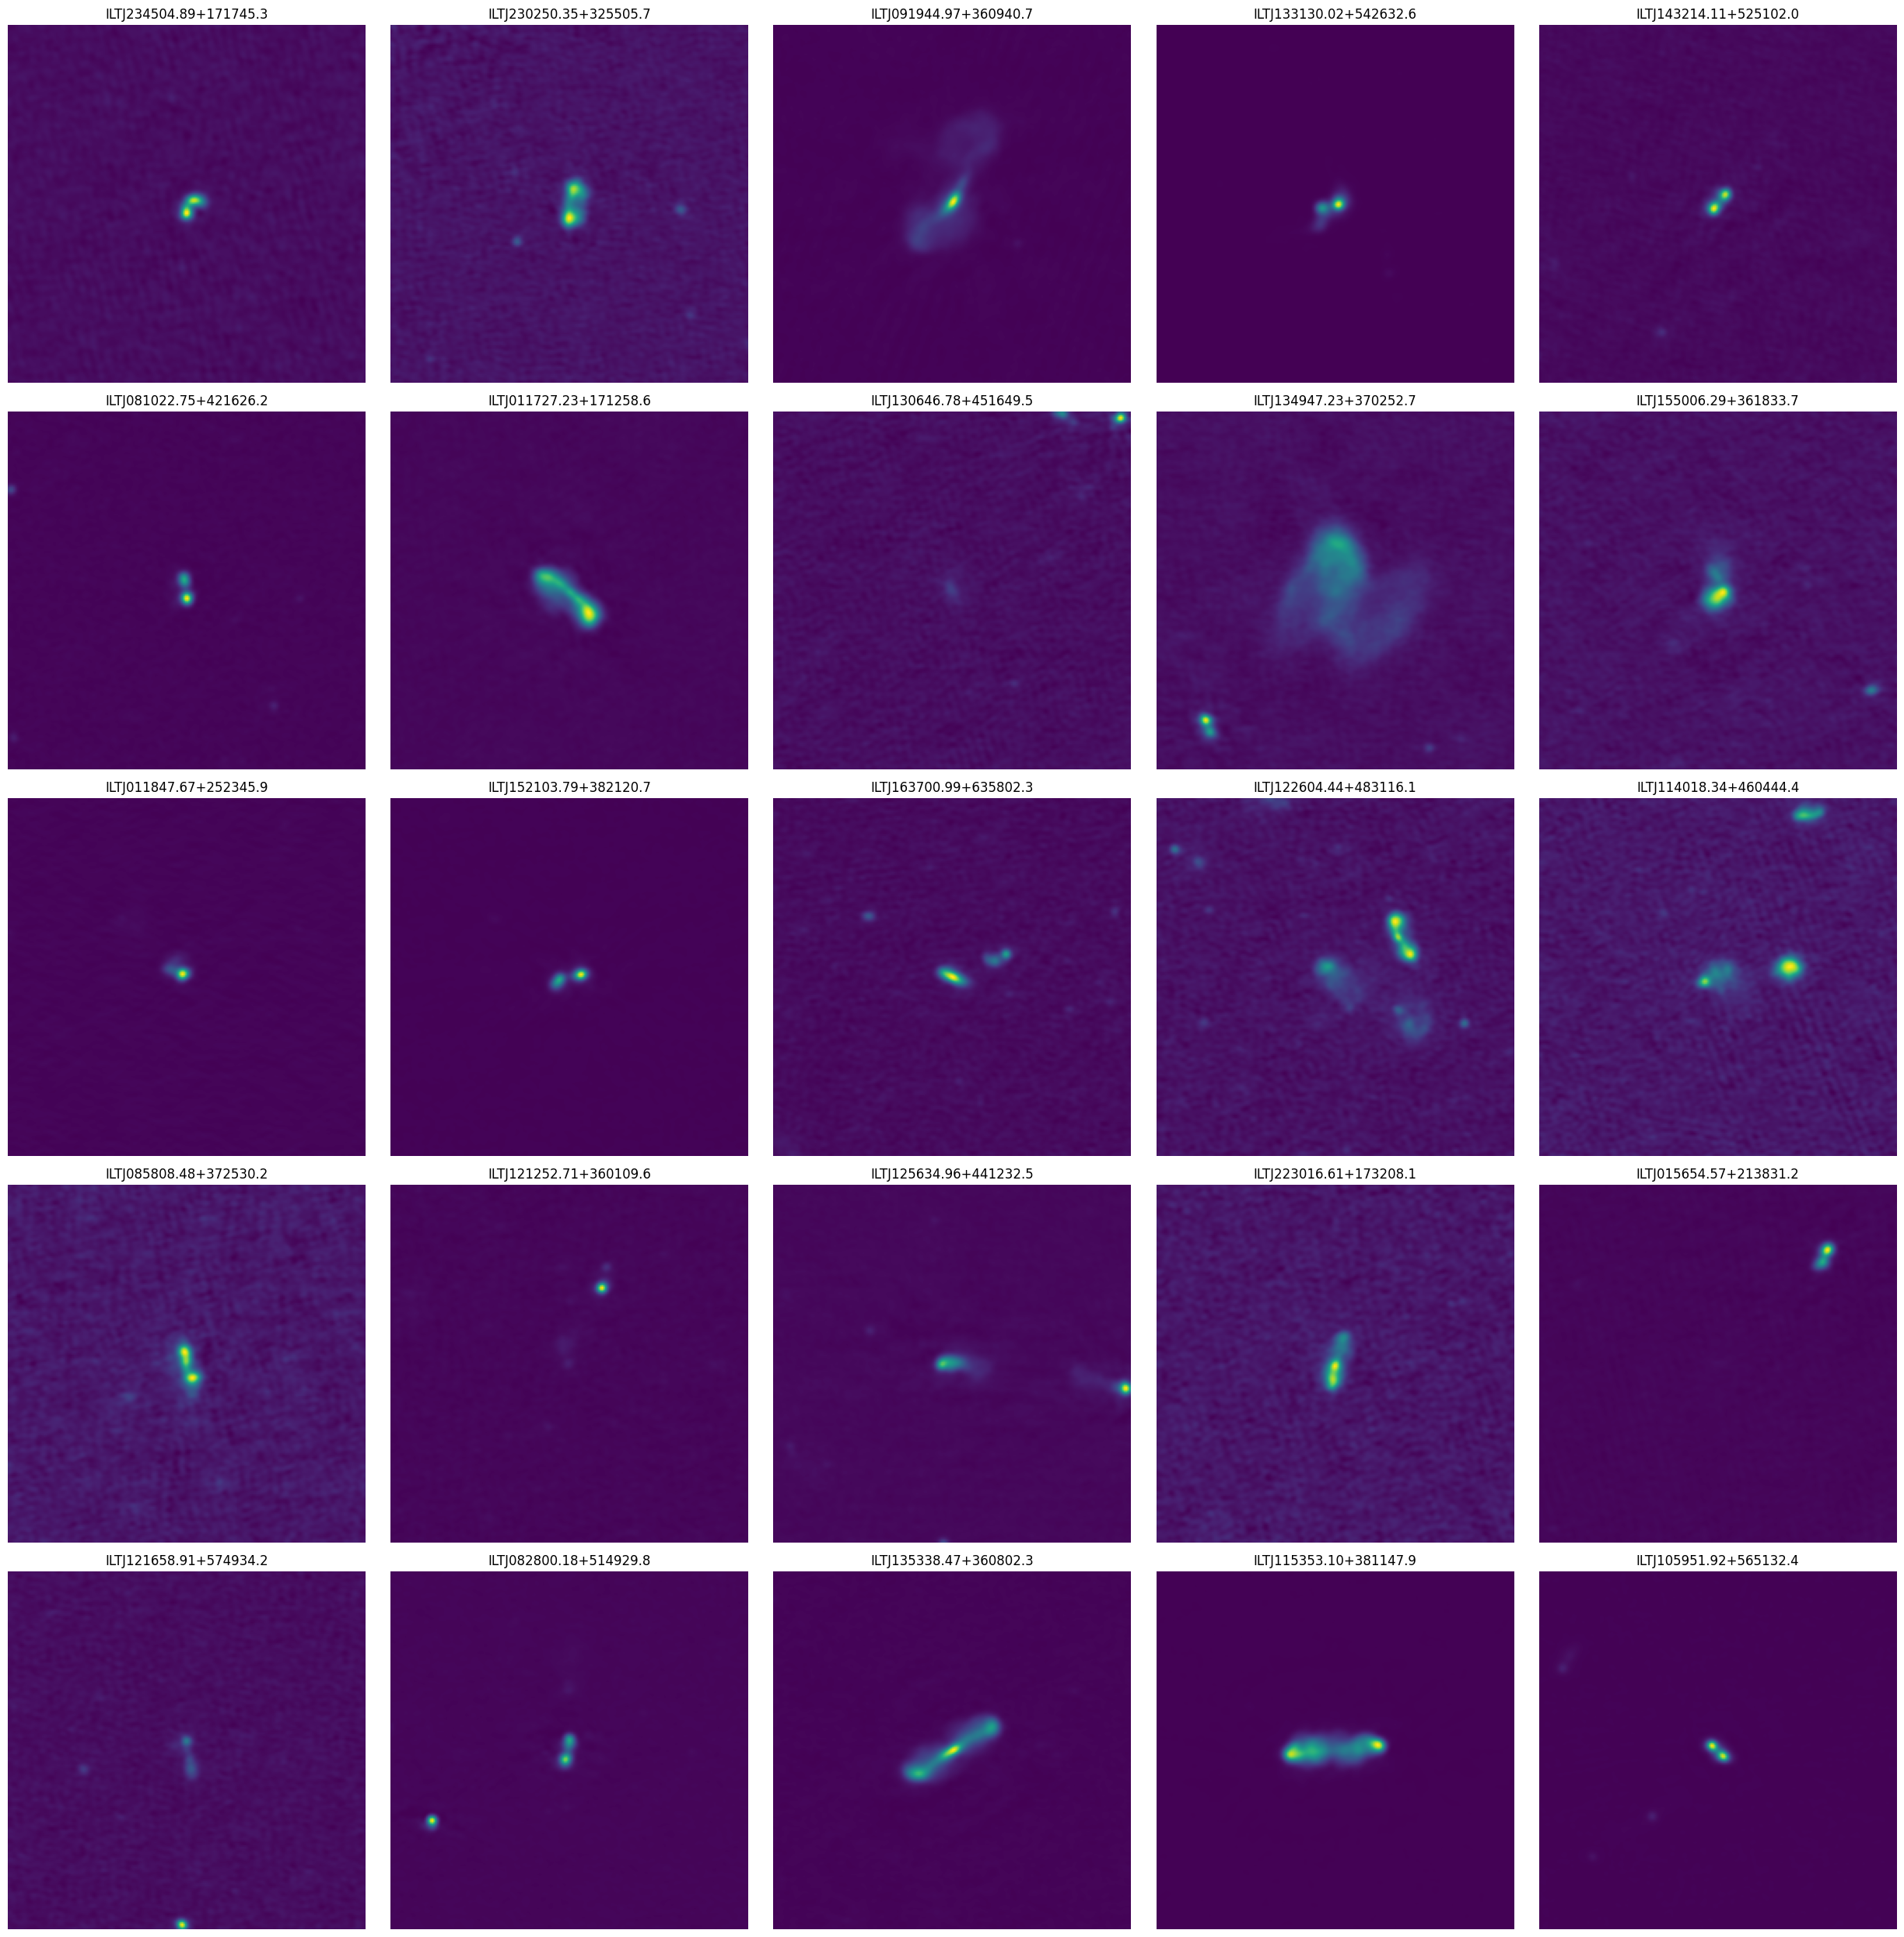

In [53]:
import numpy as np
from plotting.image_plots import plot_image_grid

def plot_tag_examples(tag, n_examples=25):
    sources = search_sources_by_tag(tag, tags_lofar)
    if len(sources) == 0:
        print(f"No sources with tag {tag}")
        return
    
    if len(sources) > n_examples:
        sources = np.random.choice(sources, n_examples, replace=False)

    images = [
        lofar_dset[idxs_lofar[source]].numpy().squeeze()
        for source in sources
    ]

    plot_image_grid(
        images,
        titles=sources,
    )
    return sources

sources = plot_tag_examples('disk')

In [29]:
tags_lofar[sources[19]]

['submitted',
 'dashed-ellipses',
 'no-optical-source',
 'solid-ellipse',
 'doublelobe',
 'compact']

In [40]:
import numpy as np
from tqdm import tqdm

# Create a dictionary to map elements of b to their indices
b_index_map = {value: idx for idx, value in enumerate(tqdm(lofar_dset.names))}

# Use the dictionary to find the indices of elements from a in b
sel_idxs = np.array(
    [b_index_map[value] for value in proto_dset.mask_metadata.Host_Source.values]
)

lofar_subset = lofar_dset.index_sliced(sel_idxs)

  0%|          | 0/127559 [00:00<?, ?it/s]

100%|██████████| 127559/127559 [00:00<00:00, 2086951.12it/s]


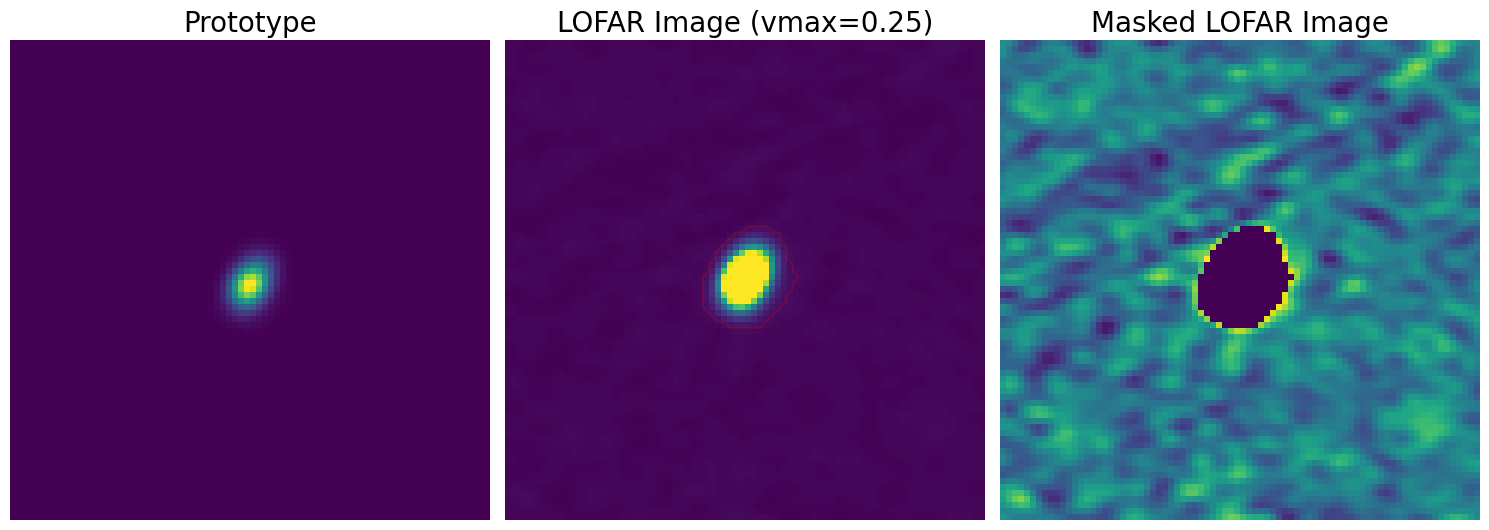

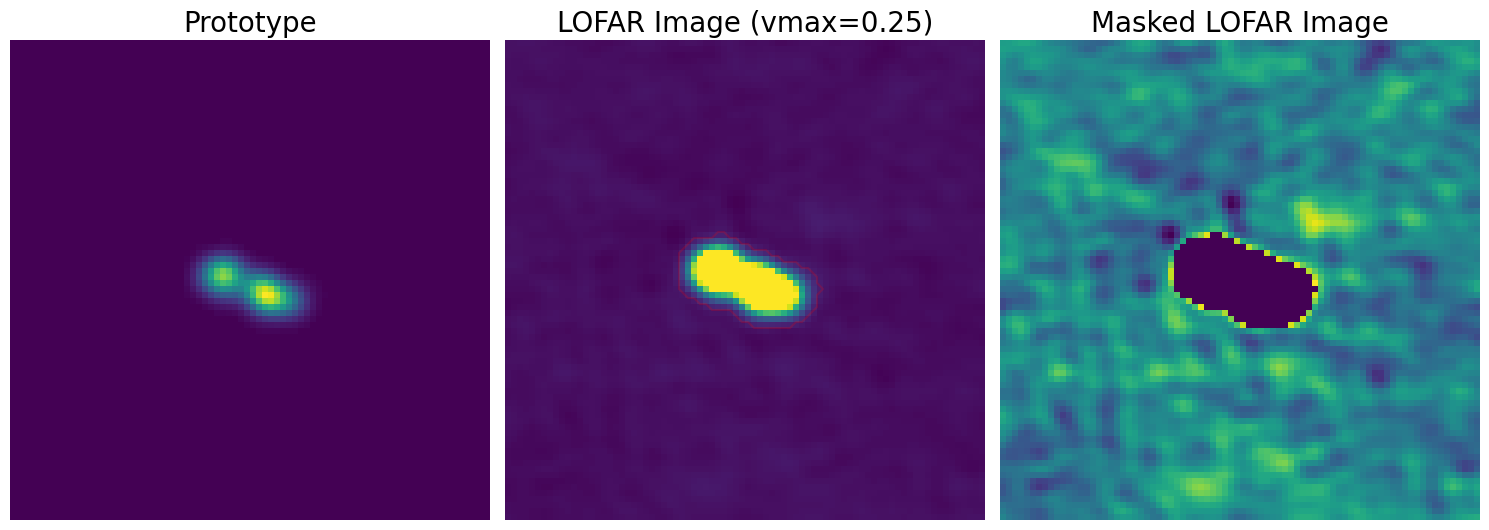

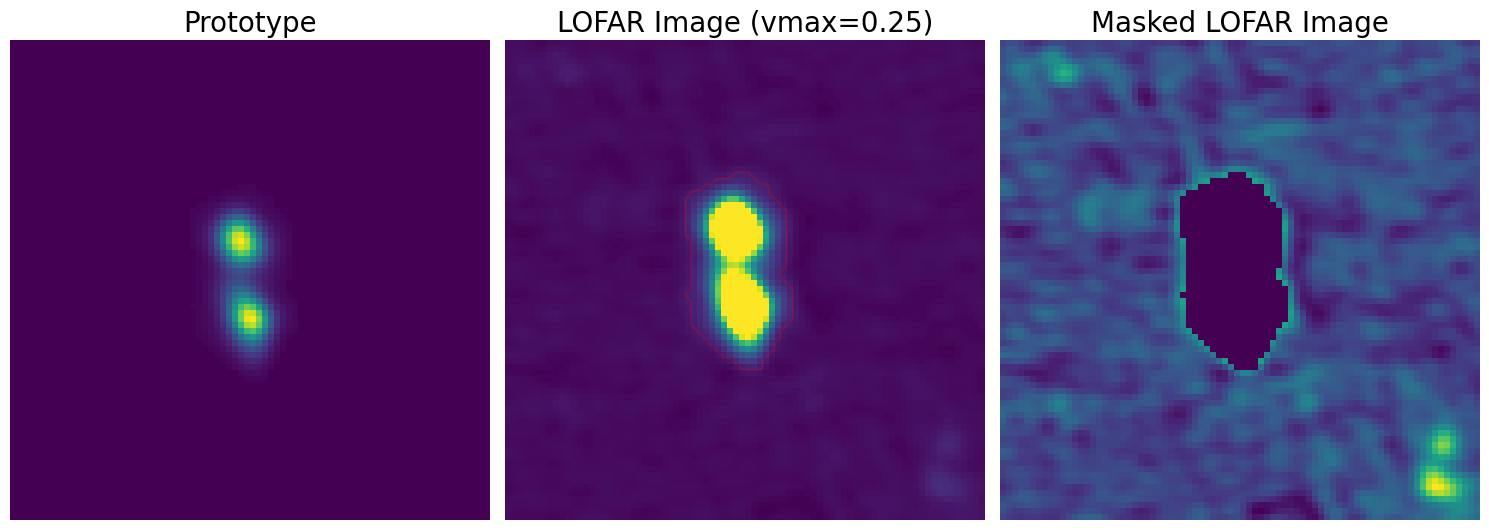

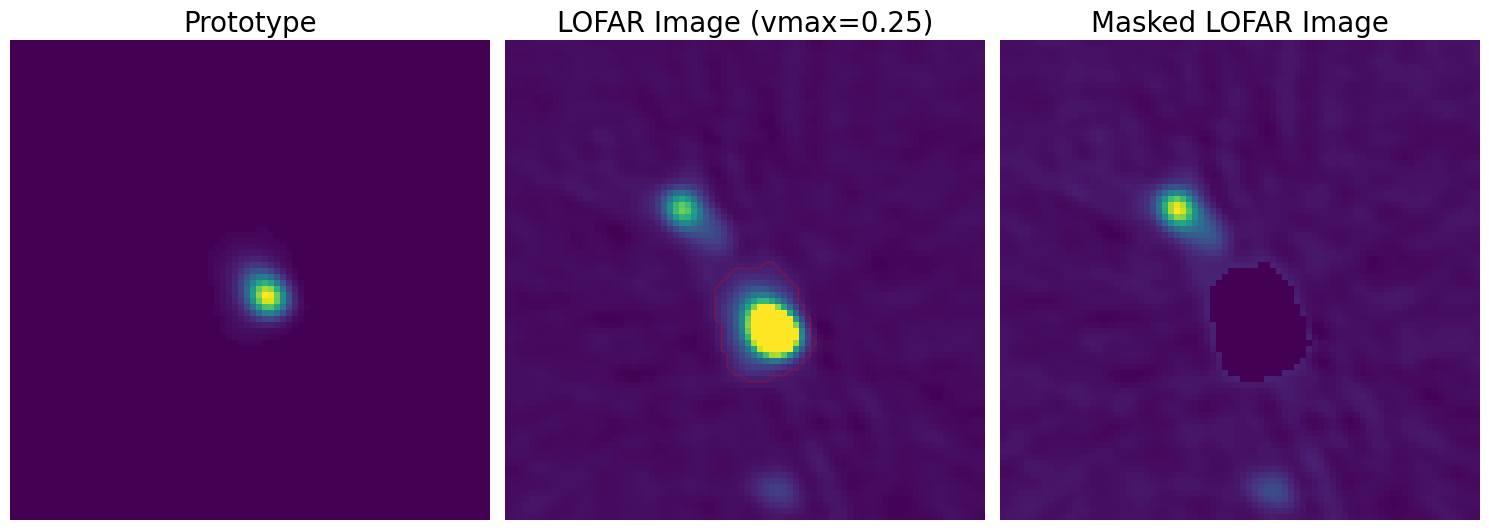

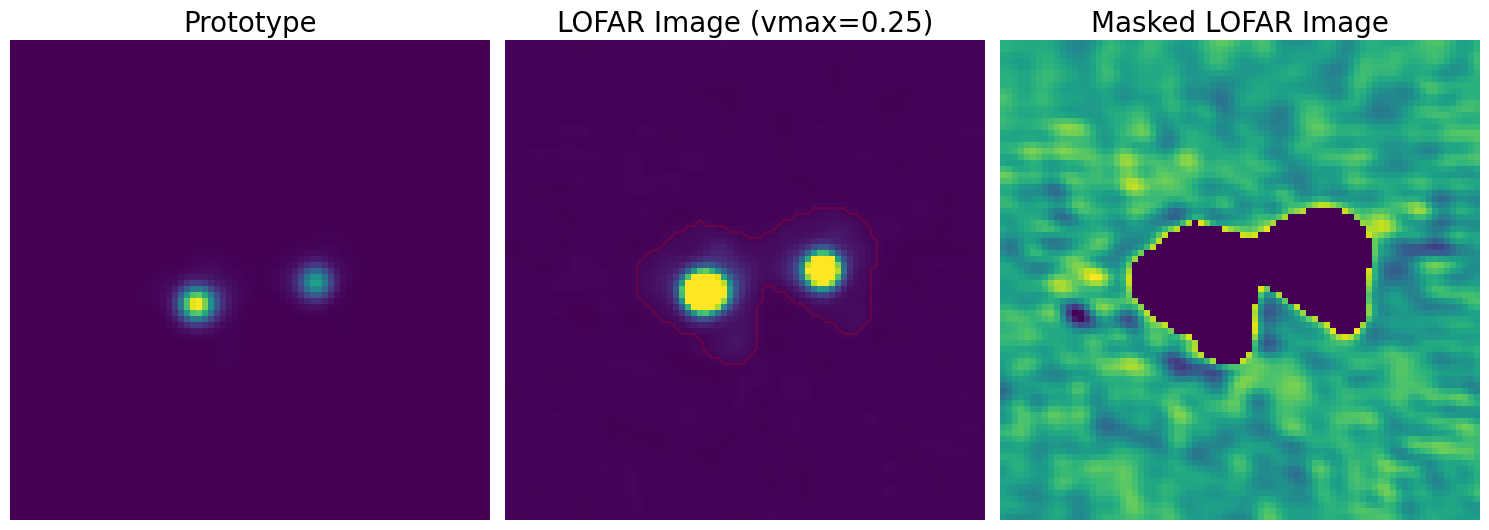

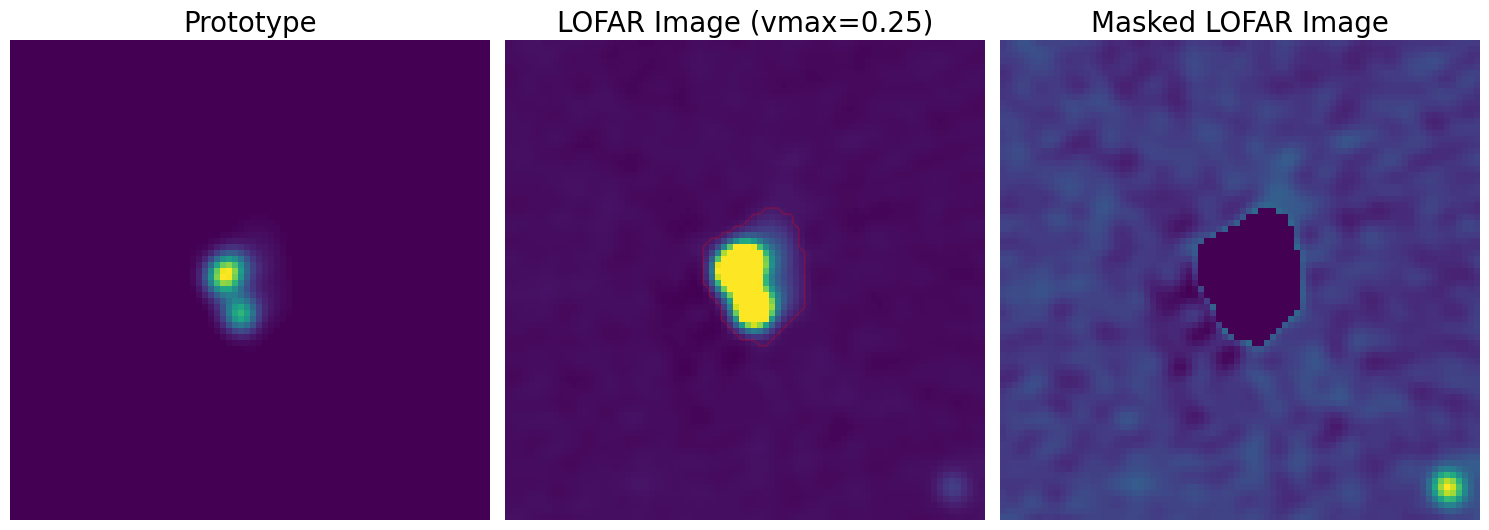

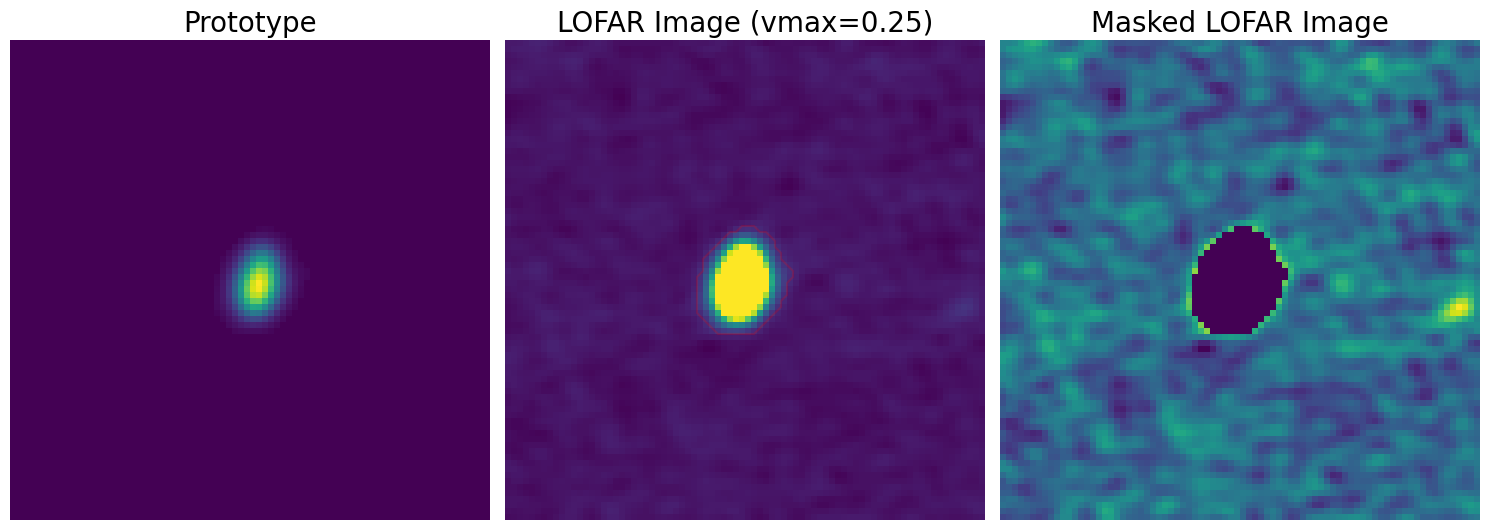

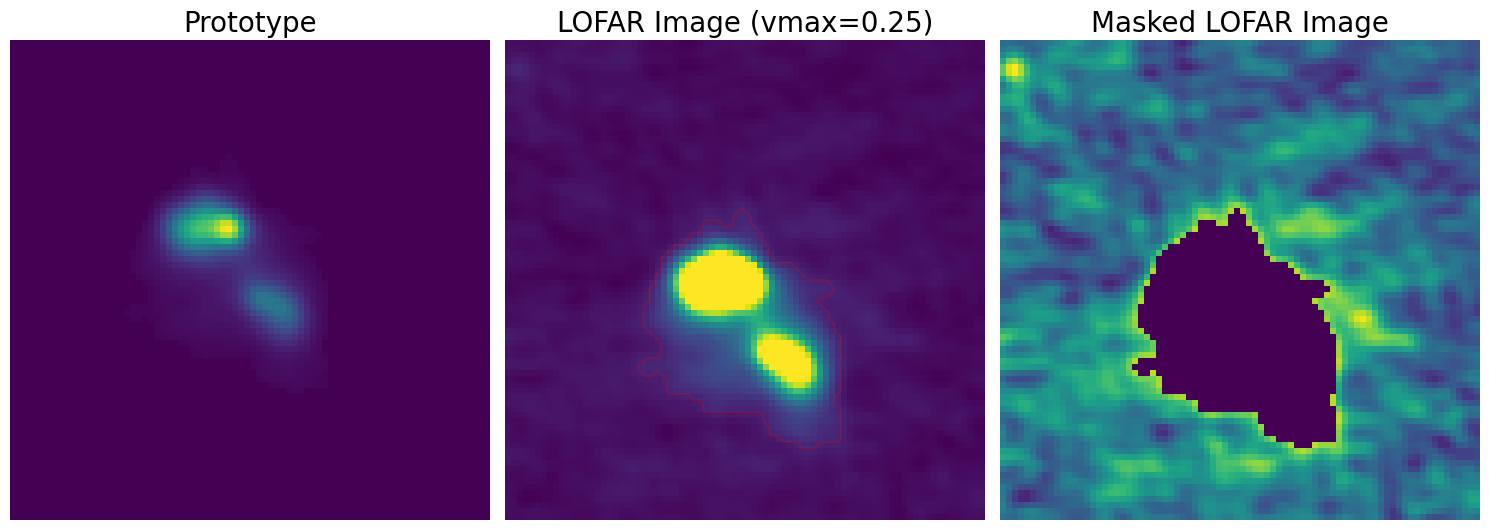

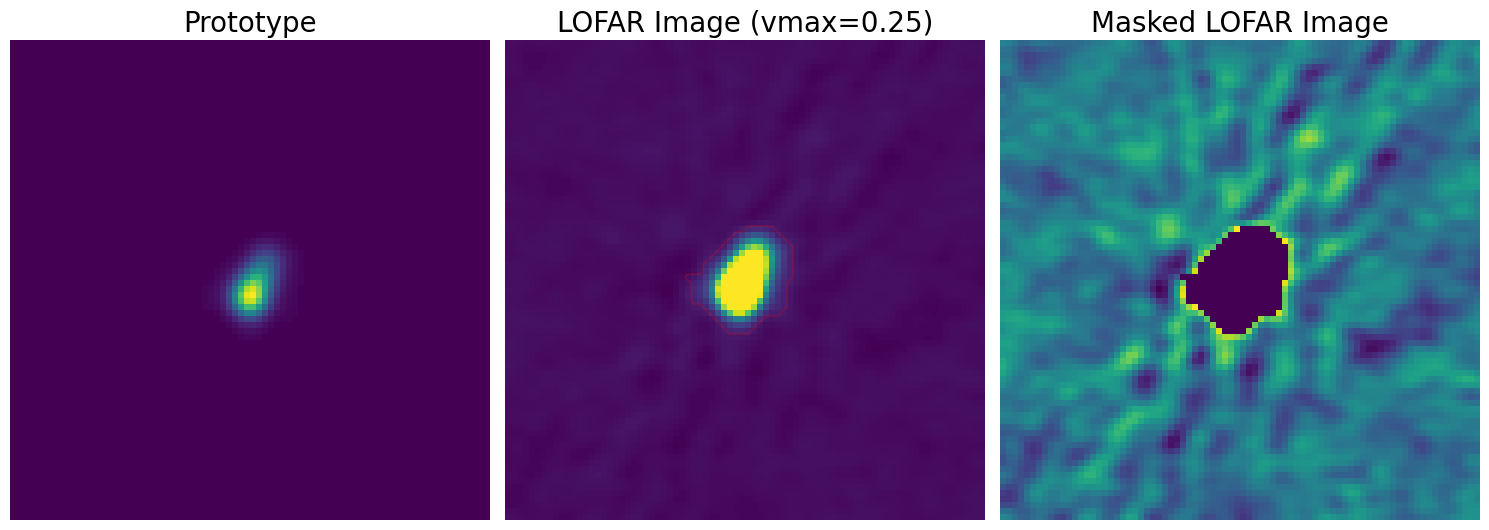

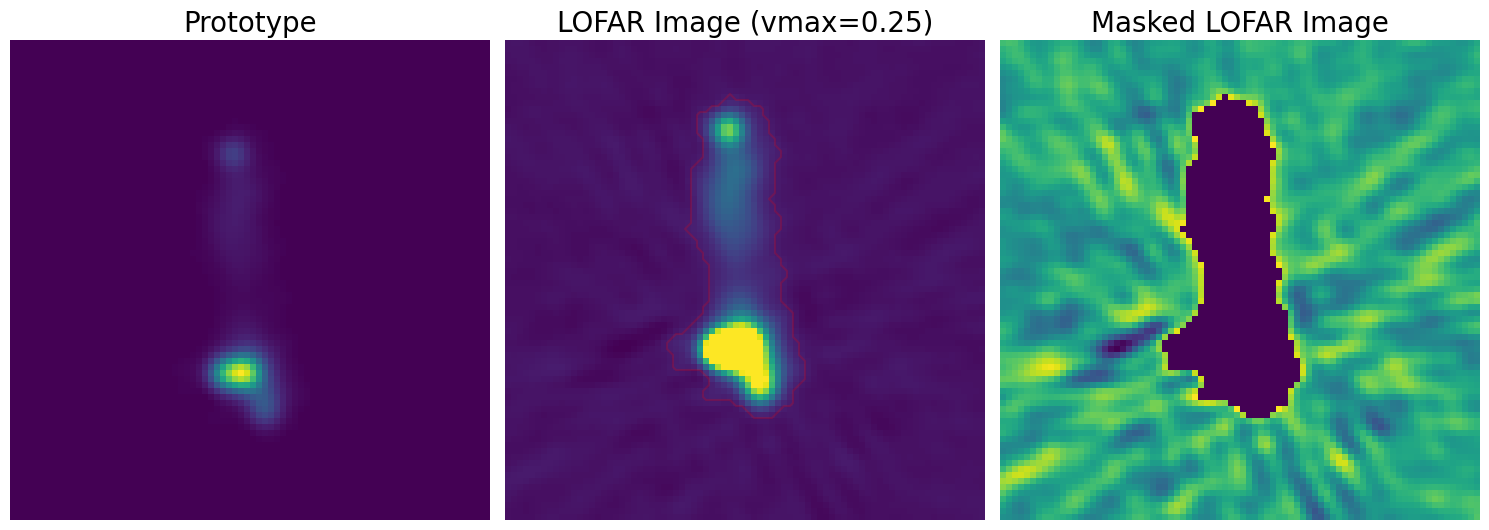

In [79]:
import matplotlib.pyplot as plt

cmap = "viridis"
cutout = lambda img: img[60:-60, 60:-60]

ii = np.random.choice(len(proto_dset), 10, replace=False)

for i in ii:
    fig, axs = plt.subplots(1, 3, figsize=(15, 6), tight_layout=True)

    proto = proto_dset[i].squeeze()
    img = cutout(lofar_subset[i].squeeze())
    mask = cutout(lofar_subset.masks[i])

    axs[0].imshow(proto, cmap=cmap)
    axs[0].set_title("Prototype", fontsize=20)

    axs[1].imshow(img, cmap=cmap, vmax=0.25)
    axs[1].set_title("LOFAR Image (vmax=0.25)", fontsize=20)
    axs[1].contour(mask, levels=[0.5], colors="r", alpha=0.2)

    axs[2].imshow(img * (1 - mask), cmap=cmap)
    axs[2].set_title("Masked LOFAR Image", fontsize=20)

    for ax in axs.flatten():
        ax.axis("off")

    fig.show()

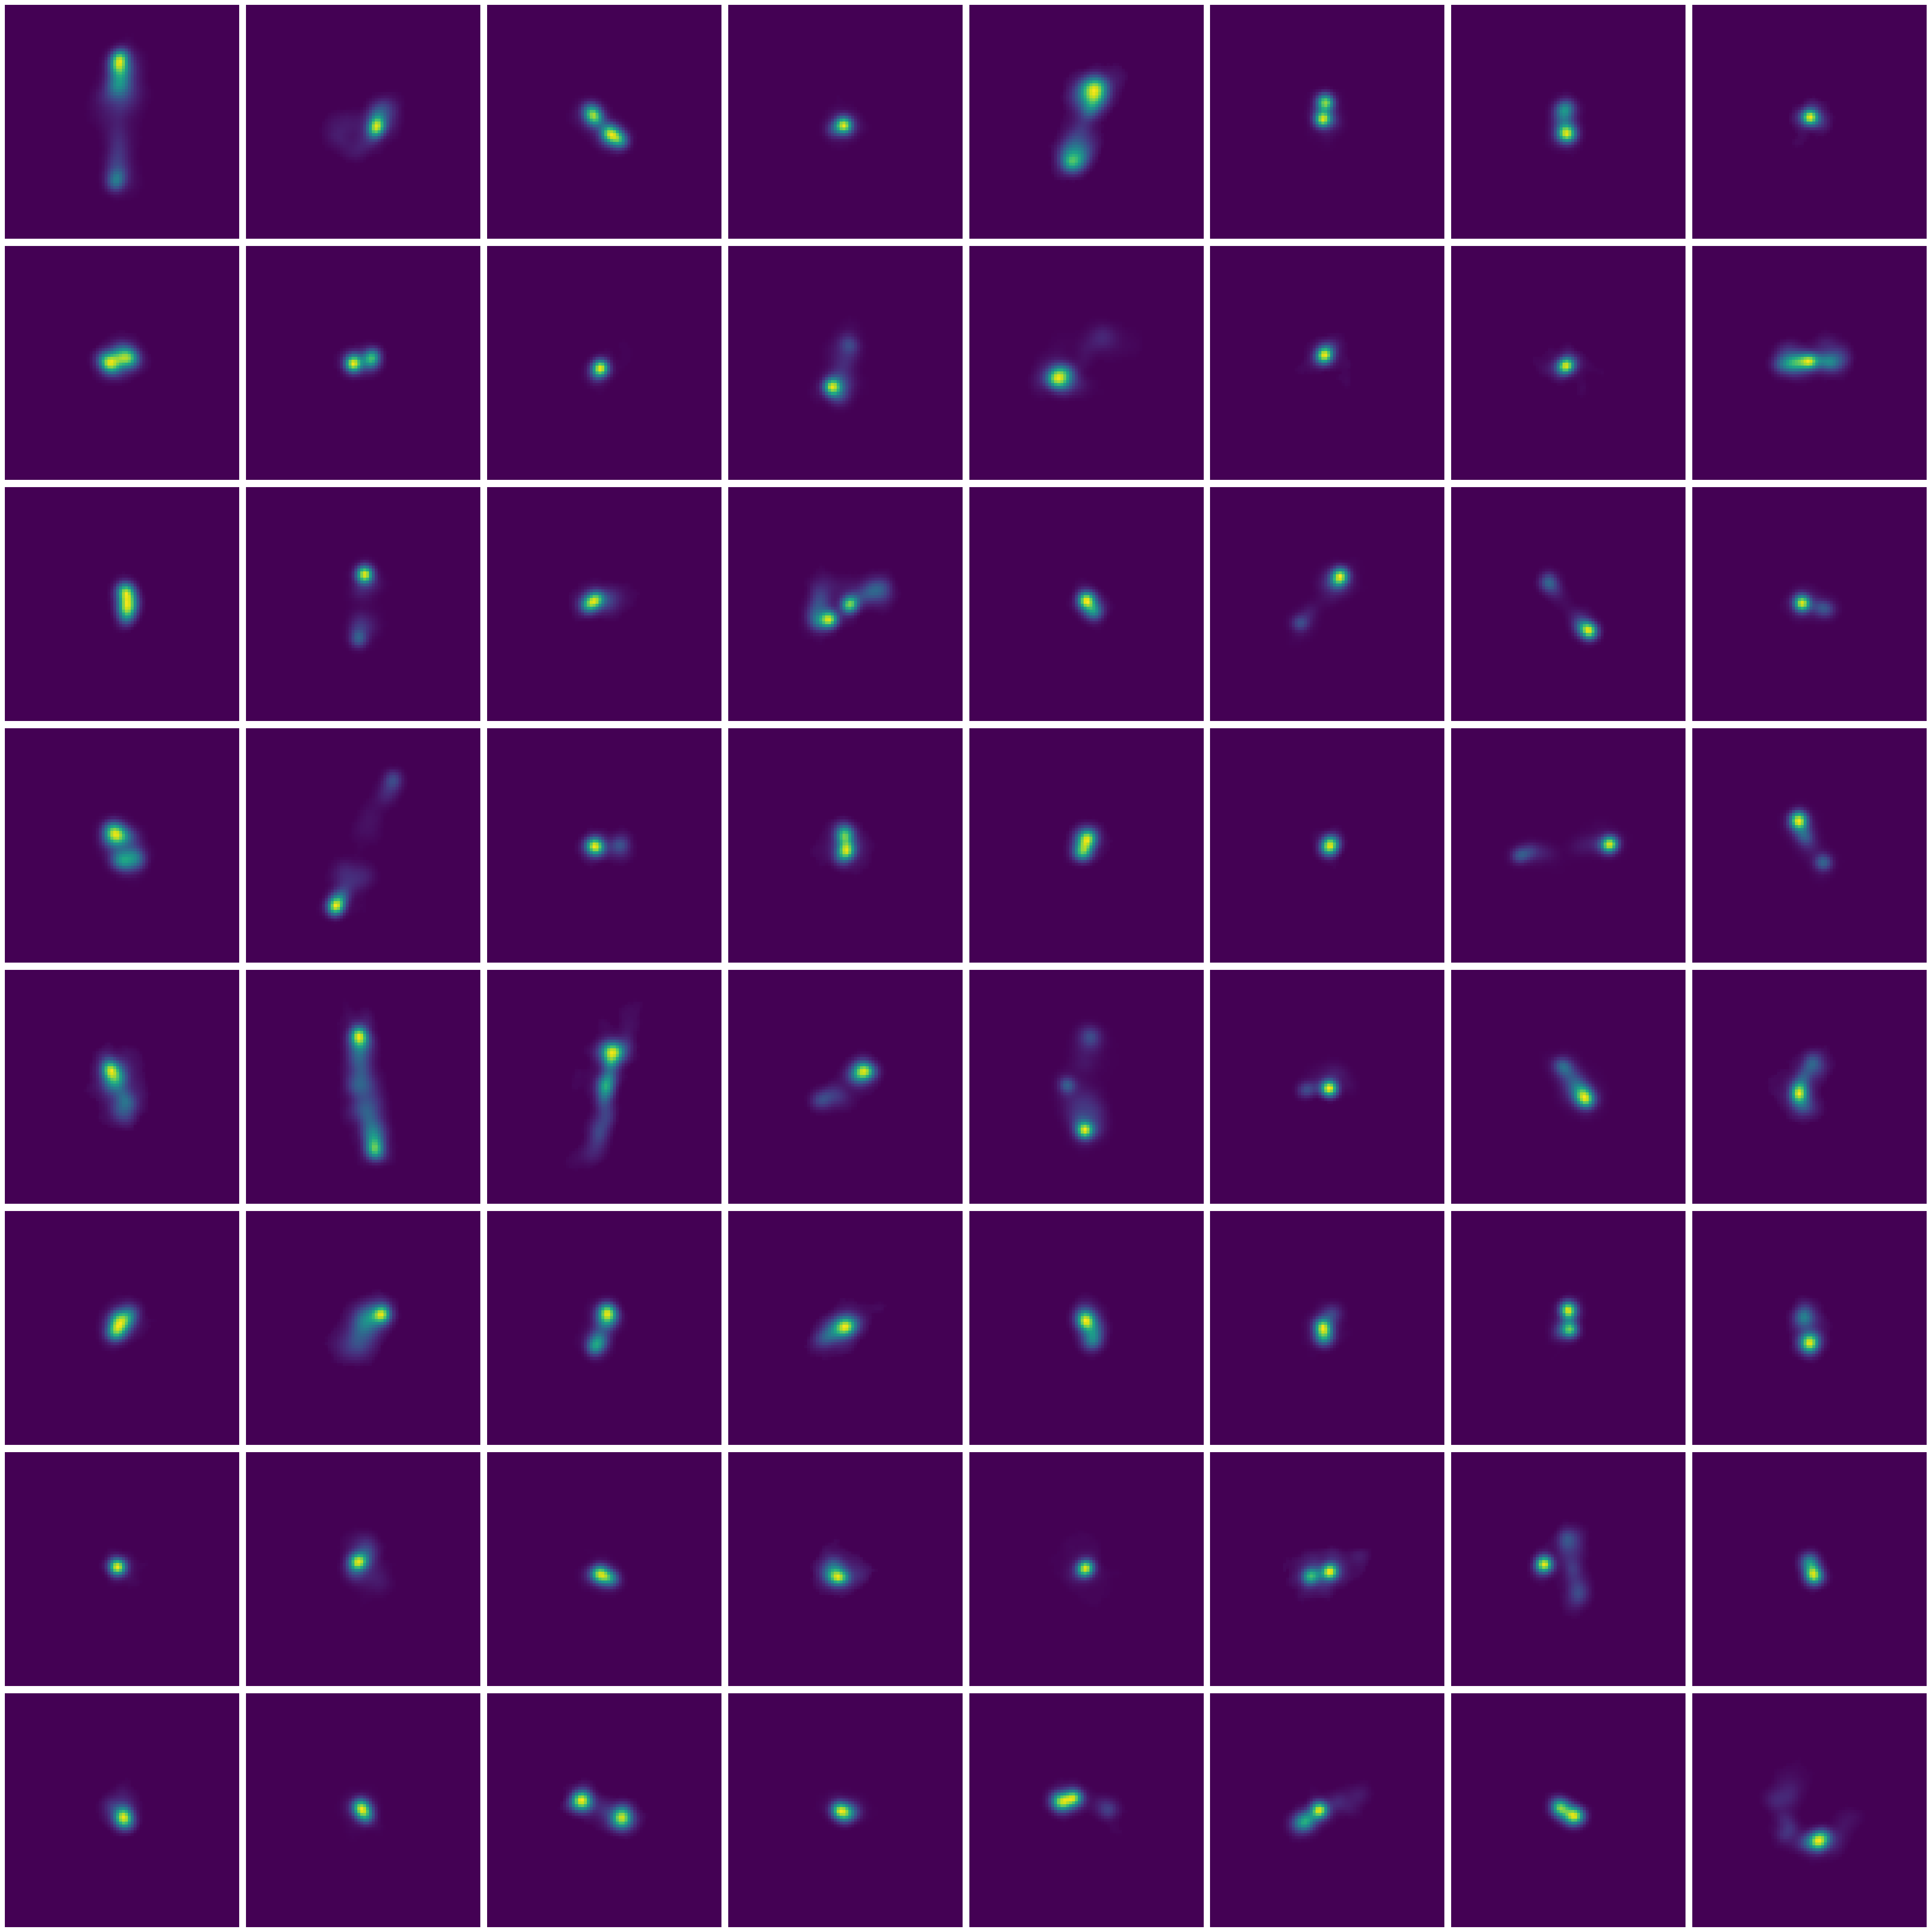

In [65]:
dataset.plot_image_grid(show_titles=False)

In [84]:
import data.datasets as datasets

reload(datasets)
from data.datasets import SamplesDataset

samples_dset = SamplesDataset("Prototypes_Model")

INFO (data.datasets): Loading images...
INFO (data.datasets): No names loaded from hdf5 file.
INFO (data.datasets): Data set initialized.


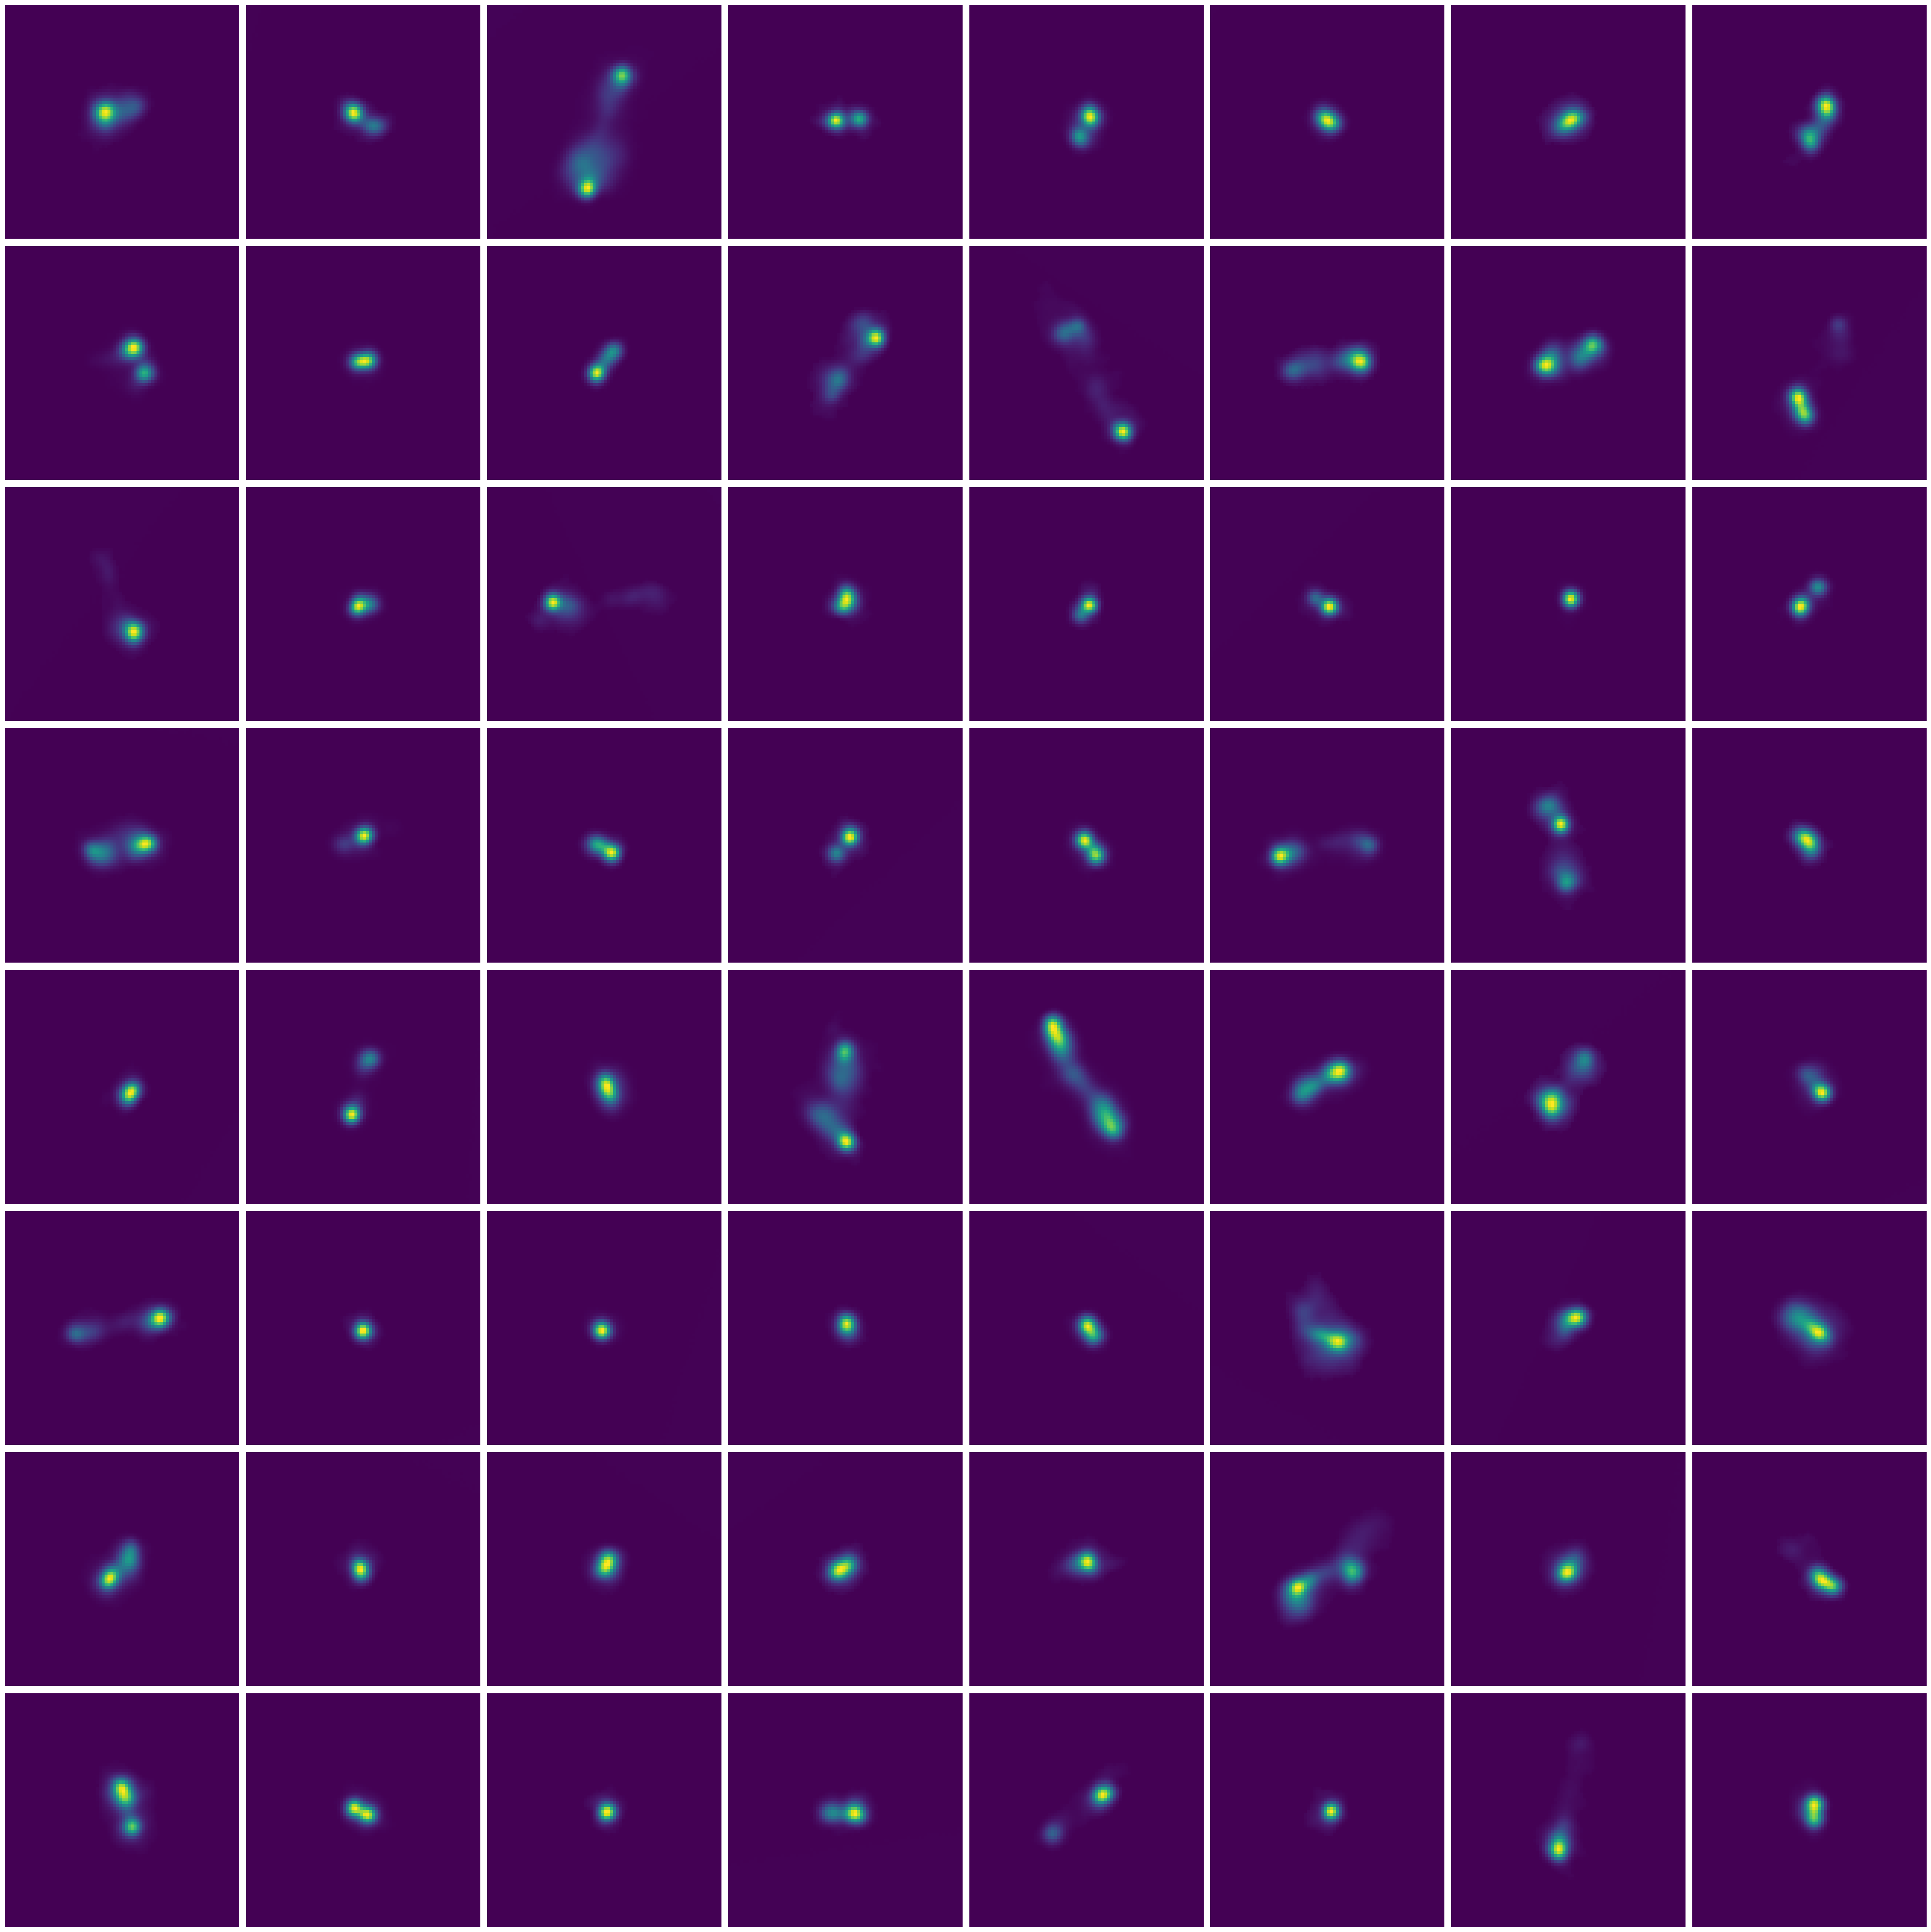

In [86]:
samples_dset.plot_image_grid(show_titles=False)

In [87]:
from skimage.draw import disk
from matplotlib.patches import Circle
import numpy as np
from data.segment import expand_islands, smooth_mask
from scipy.ndimage import binary_dilation


def circular_mask(shape, center=None, radius=None):
    if center is None:
        center = np.array(shape) // 2
    if radius is None:
        radius = min(center)
    mask = np.zeros(shape, dtype=bool)
    rr, cc = disk(center, radius, shape=shape)
    mask[rr, cc] = True
    return mask


def circle_patch(img):
    return Circle(
        (img.shape[1] // 2, img.shape[0] // 2),
        img.shape[0] // 2,
        fill=False,
        color="w",
    )


def get_source_mask(img, expand=False, dilate=0):
    cmask = circular_mask(img.shape)
    safe_background = img[~cmask].flatten()
    source_mask = img > np.mean(safe_background) + 3 * safe_background.std()

    # Iteratively expand to 1 sigma
    if expand:
        i = 0
        while i < 10:
            background = img[~source_mask].flatten()
            exp_mask = img > np.mean(background) + 1.5 * background.std()
            if np.all(exp_mask == source_mask):
                break
            source_mask = expand_islands(source_mask, exp_mask)
            i += 1

    source_mask = smooth_mask(source_mask)

    if dilate:
        source_mask = binary_dilation(source_mask, iterations=dilate)

    return source_mask

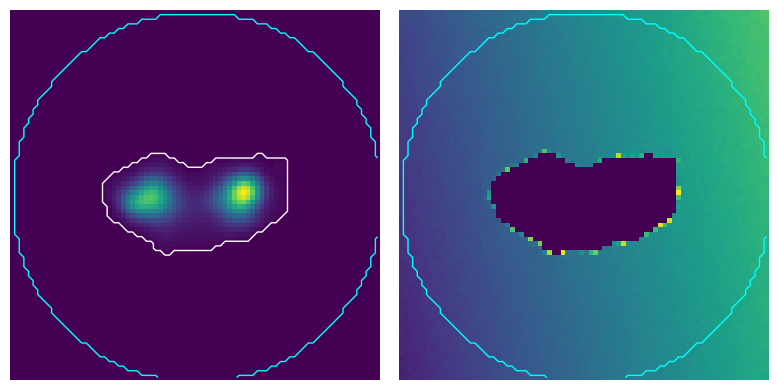

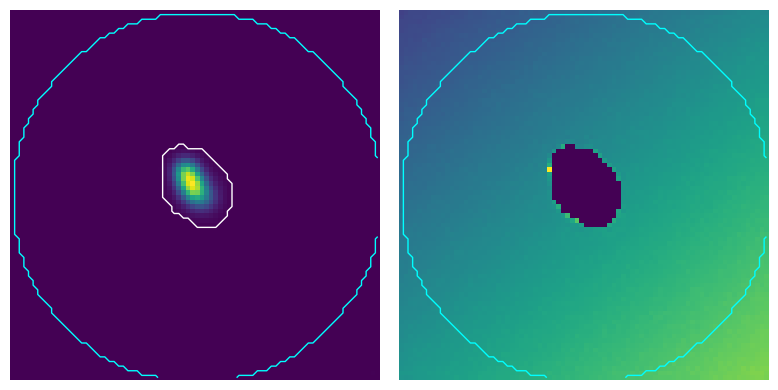

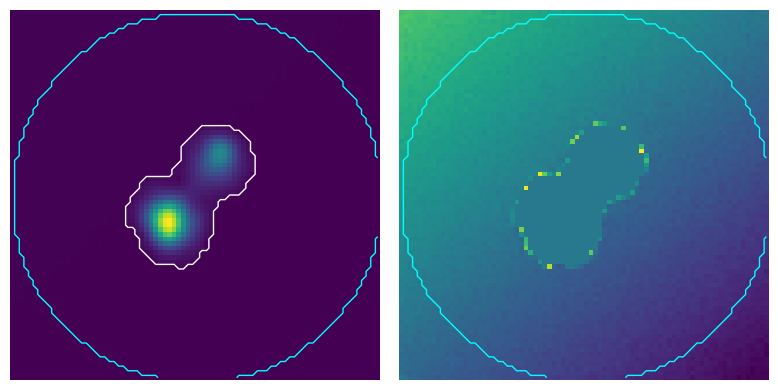

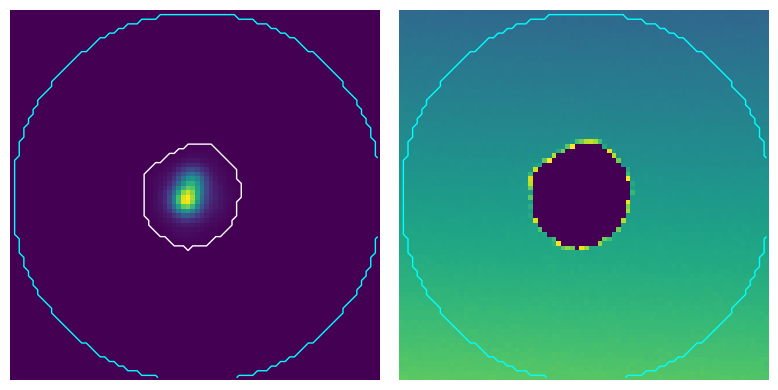

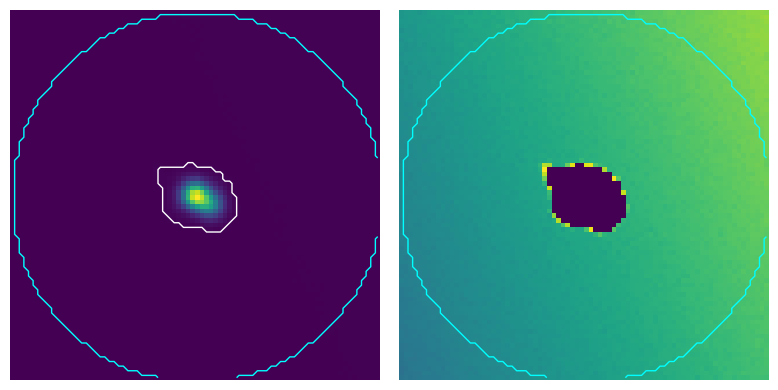

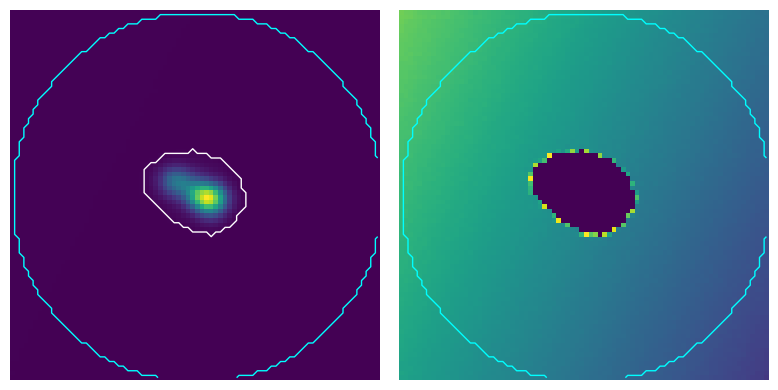

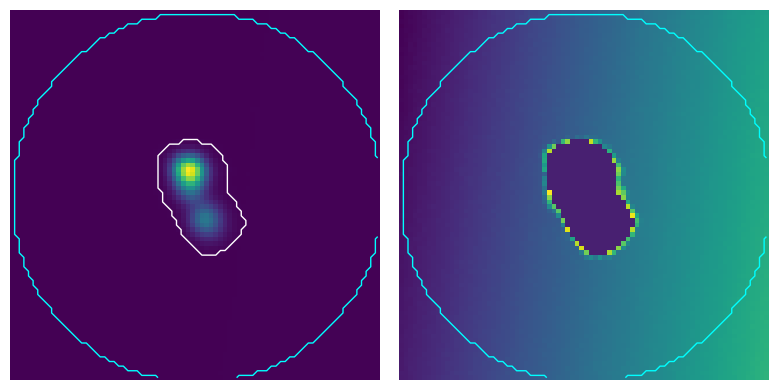

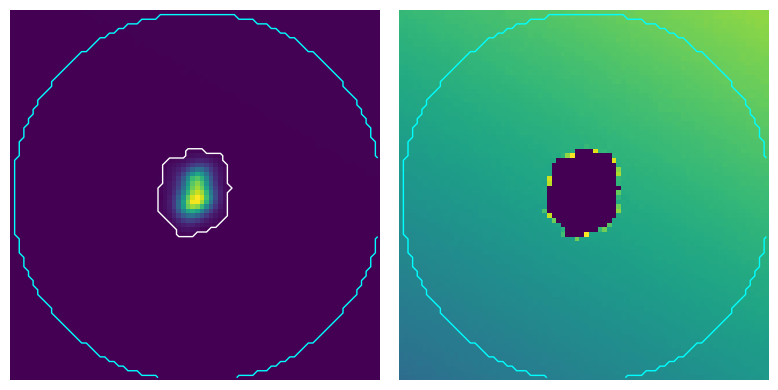

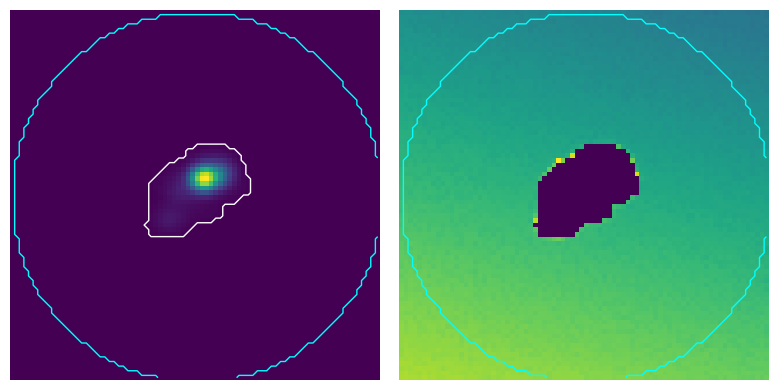

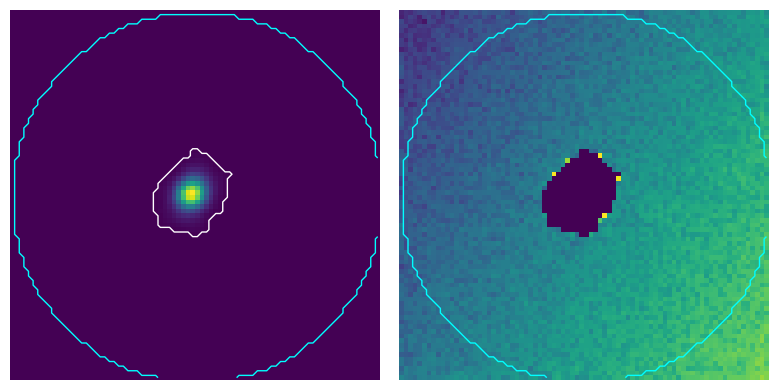

In [99]:
# Plot masks & Background Distributions
ii = np.random.choice(len(samples_dset), 10, replace=False)

plot_histograms = False

for i in ii:
    img = samples_dset.data[i].numpy().squeeze()
    cmask = circular_mask(img.shape)
    safe_background = img[~cmask].flatten()
    seed_mask = img > np.mean(safe_background) + 3 * safe_background.std()
    source_mask = get_source_mask(img, dilate=0)

    fig, axss = plt.subplots(
        1 + int(plot_histograms),
        2,
        figsize=(10, 8) if plot_histograms else (8, 4),
        tight_layout=True,
        gridspec_kw={"height_ratios": [2, 1]} if plot_histograms else None,
    )

    axs = axss
    if plot_histograms:
        axs = axss[0]

    ax = axs[0]
    ax.imshow(img)
    ax.contour(source_mask, levels=[0.5], colors="w", linewidths=1)
    # ax.contour(seed_mask, levels=[0.5], colors="orange", linewidths=1)
    ax.contour(cmask, levels=[0.5], colors="cyan", linewidths=1)
    ax.axis("off")

    ax = axs[1]
    ax.imshow(img * (1 - source_mask))
    ax.contour(cmask, levels=[0.5], colors="cyan", linewidths=1)
    ax.axis("off")

    if plot_histograms:
        axs = axss[1]

        ax = axs[1][0]
        ax.hist(img.flatten(), bins=100)
        ax.set_yscale("log")
        ax.set_xlabel("Pixel value")
        ax.set_ylabel("Counts")
        ax.grid(alpha=0.3)

        # Annotation box with min and max
        min_val = np.min(img)
        max_val = np.max(img)
        ax.set_title(f"Pixel value histogram\nMin: {min_val:.5f} -- Max: {max_val:.5f}")

        ax = axs[1][1]
        ax.hist(safe_background, bins=100, label="Safe Bg.", alpha=0.7, histtype="step")
        if (~source_mask).sum() > 0:
            ax.hist(
                img[~source_mask].flatten(),
                bins=100,
                label="Off-Mask Bg.",
                alpha=0.7,
                histtype="step",
            )
        ax.set_yscale("log")
        ax.set_xlabel("Pixel value")
        ax.set_ylabel("Counts")
        ax.grid(alpha=0.3)
        ax.legend()
        # Rotate x-axis labels
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
        ax.set_title(
            f"Background pixel value histogram\nMean: {np.mean(safe_background):.5f} -- Std: {np.std(safe_background):.5f}"
        )

    fig.show()

In [121]:
from tqdm import tqdm
from data.segment import get_circle
from data.transforms import max_scale_batch

images = max_scale_batch(samples_dset.data.numpy().squeeze())
masks = np.array([get_source_mask(img, dilate=0) for img in tqdm(images)])
samples_dset.masks = torch.tensor(masks)

sample_circles = np.array([get_circle(mask) for mask in tqdm(masks)])
sample_centers, sample_radii = sample_circles[:, :2], sample_circles[:, 2]
sample_circle_masks = np.array(
    [
        circular_mask(img.shape, center=c, radius=r)
        for img, c, r in zip(images, sample_centers, sample_radii)
    ]
)
sample_compactness = (masks * sample_circle_masks).sum(
    axis=(1, 2)
) / sample_circle_masks.sum(axis=(1, 2))

sample_mask_areas = masks.sum(axis=(1, 2)) 
sample_source_pixels = images[masks]
sample_source_means = [np.mean(img[mask]) for img, mask in tqdm(zip(images, masks), total=len(images))]
sample_source_stds = [np.std(img[mask]) for img, mask in tqdm(zip(images, masks), total=len(images))]

100%|██████████| 8000/8000 [00:00<00:00, 34603.76it/s]


In [101]:
from utils import paths
import data.datasets

reload(data.datasets)
from data.datasets import LOFARPrototypesDataset

proto_dset = LOFARPrototypesDataset(
    paths.LOFAR_SUBSETS["prototypes"],
    train_mode=False,
    img_size=80,
)
proto_radii = proto_dset.mask_metadata["Model_Radius"].values

INFO (data.datasets): Loading images...
INFO (data.datasets): Loading names from catalog...
INFO (data.datasets): Loading 'masks'...
INFO (data.datasets): Data set initialized.
INFO (data.datasets): Loading mask metadata...
INFO (data.datasets): Image size 80: Removing sources with model_radius > 40.0...
INFO (data.datasets): Removed 571 of 23_817 sources (2.4%).
INFO (data.datasets): Reshaping images...
INFO (data.datasets): Reshaping masks...


In [122]:
proto_circle_masks = np.array(
    [circular_mask((80,) * 2, radius=r) for r in tqdm(proto_radii)]
)
proto_compactness = (proto_dset.masks.numpy() * proto_circle_masks).sum(
    axis=(1, 2)
) / proto_circle_masks.sum(axis=(1, 2))

proto_mask_areas = proto_dset.masks.sum(axis=(1, 2))
proto_source_pixels = proto_dset.data.numpy()[proto_dset.masks.numpy().astype(bool)]
proto_source_means = [np.mean(img[mask]) for img, mask in tqdm(zip(proto_dset.data.numpy(), proto_dset.masks.numpy().astype(bool)), total=len(proto_dset))]
proto_source_stds = [np.std(img[mask]) for img, mask in tqdm(zip(proto_dset.data.numpy(), proto_dset.masks.numpy().astype(bool)), total=len(proto_dset))]

100%|██████████| 23246/23246 [00:00<00:00, 35275.06it/s]


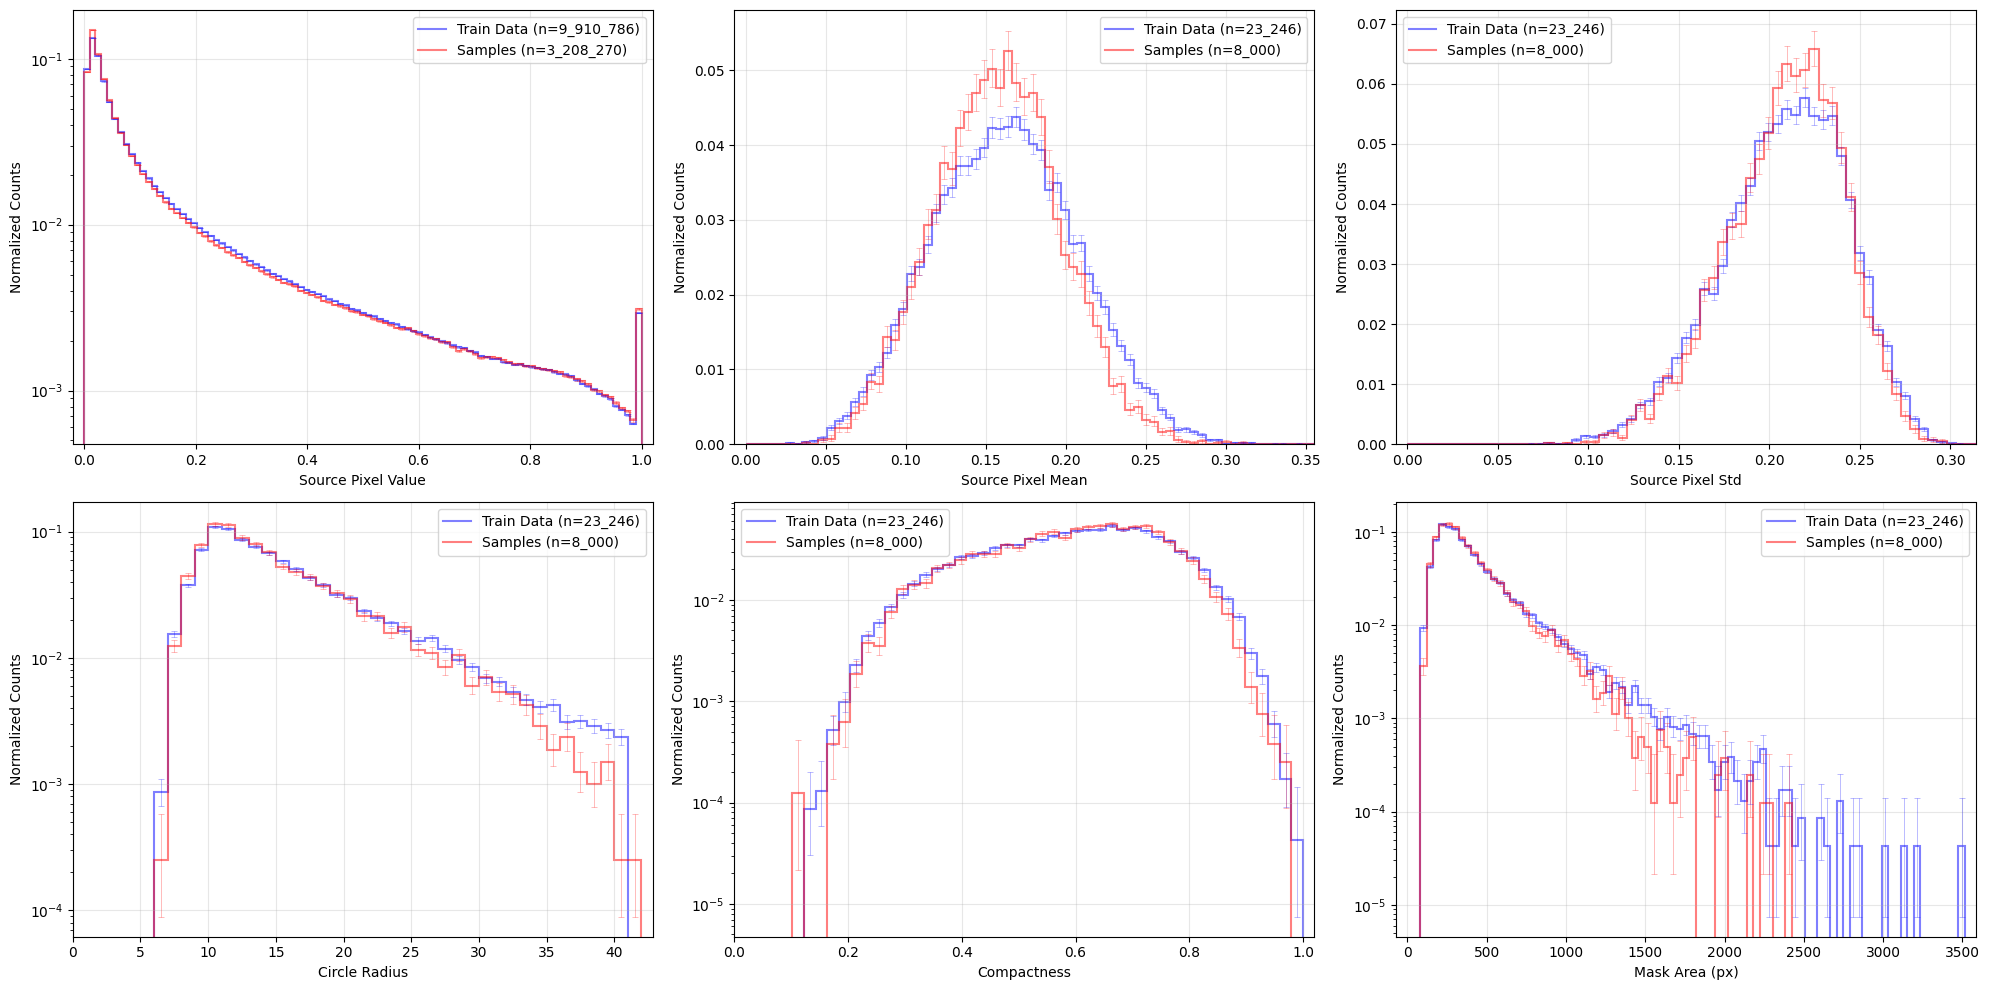

In [130]:
from plotting.plot_utils import add_distribution_plot

fig, axs = plt.subplots(2, 3, figsize=(20, 10), tight_layout=True)

# Source pixel value distribution
ax = axs[0][0]
edg = np.linspace(0, 1, 100)
c_prot, edg_prot = np.histogram(proto_source_pixels, bins=edg)
c_smpl, edg_smpl = np.histogram(sample_source_pixels, bins=edg)

add_distribution_plot(c_prot, edg, ax, label="Train Data", color="b")
add_distribution_plot(c_smpl, edg, ax, label="Samples", color="r")

ax.set_xlabel("Source Pixel Value")
ax.set_ylabel("Normalized Counts")
ax.grid(alpha=0.3)
ax.legend()
ax.set_yscale("log")

# Source mean distribution
ax = axs[0][1]
edg = np.linspace(0, 0.5, 100)
c_prot, edg_prot = np.histogram(proto_source_means, bins=edg)
c_smpl, edg_smpl = np.histogram(sample_source_means, bins=edg)

add_distribution_plot(c_prot, edg, ax, label="Train Data", color="b")
add_distribution_plot(c_smpl, edg, ax, label="Samples", color="r")

ax.set_xlabel("Source Pixel Mean")
ax.set_ylabel("Normalized Counts")
ax.grid(alpha=0.3)
ax.legend()

# Source std distribution
ax = axs[0][2]
edg = np.linspace(0, 0.5, 100)
c_prot, edg_prot = np.histogram(proto_source_stds, bins=edg)
c_smpl, edg_smpl = np.histogram(sample_source_stds, bins=edg)

add_distribution_plot(c_prot, edg, ax, label="Train Data", color="b")
add_distribution_plot(c_smpl, edg, ax, label="Samples", color="r")

ax.set_xlabel("Source Pixel Std")
ax.set_ylabel("Normalized Counts")
ax.grid(alpha=0.3)
ax.legend()

# Mask area distribution
ax = axs[1][2]
edg = np.linspace(0, 4000, 100)
c_prot, edg_prot = np.histogram(proto_mask_areas, bins=edg)
c_smpl, edg_smpl = np.histogram(sample_mask_areas, bins=edg)

add_distribution_plot(c_prot, edg, ax, label="Train Data", color="b")
add_distribution_plot(c_smpl, edg, ax, label="Samples", color="r")

ax.set_xlabel("Mask Area (px)")
ax.set_ylabel("Normalized Counts")
ax.grid(alpha=0.3)
ax.legend()
ax.set_yscale("log")


# Radius distribution
ax = axs[1][0]
edg = np.linspace(0, 45, 46)
c_prot, edg_prot = np.histogram(proto_radii, bins=edg)
c_smpl, edg_smpl = np.histogram(sample_radii, bins=edg)

add_distribution_plot(c_prot, edg, ax, label="Train Data", color="b")
add_distribution_plot(c_smpl, edg, ax, label="Samples", color="r")

ax.set_xlabel("Circle Radius")
ax.set_ylabel("Normalized Counts")
ax.grid(alpha=0.3)
ax.legend()
ax.set_xlim(left=0)
ax.set_yscale("log")

# Compactness distribution
ax = axs[1][1]
edg = np.linspace(0, 1, 50)
c_prot, edg_prot = np.histogram(proto_compactness, bins=edg)
c_smpl, edg_smpl = np.histogram(sample_compactness, bins=edg)

add_distribution_plot(c_prot, edg, ax, label="Train Data", color="b")
add_distribution_plot(c_smpl, edg, ax, label="Samples", color="r")

ax.set_xlabel("Compactness")
ax.set_ylabel("Normalized Counts")
ax.grid(alpha=0.3)
ax.legend()
ax.set_xlim(left=0)
ax.set_yscale("log")

for ax in axs[:, -1]:
    break
    # Put y labels on right side
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")


fig.show()

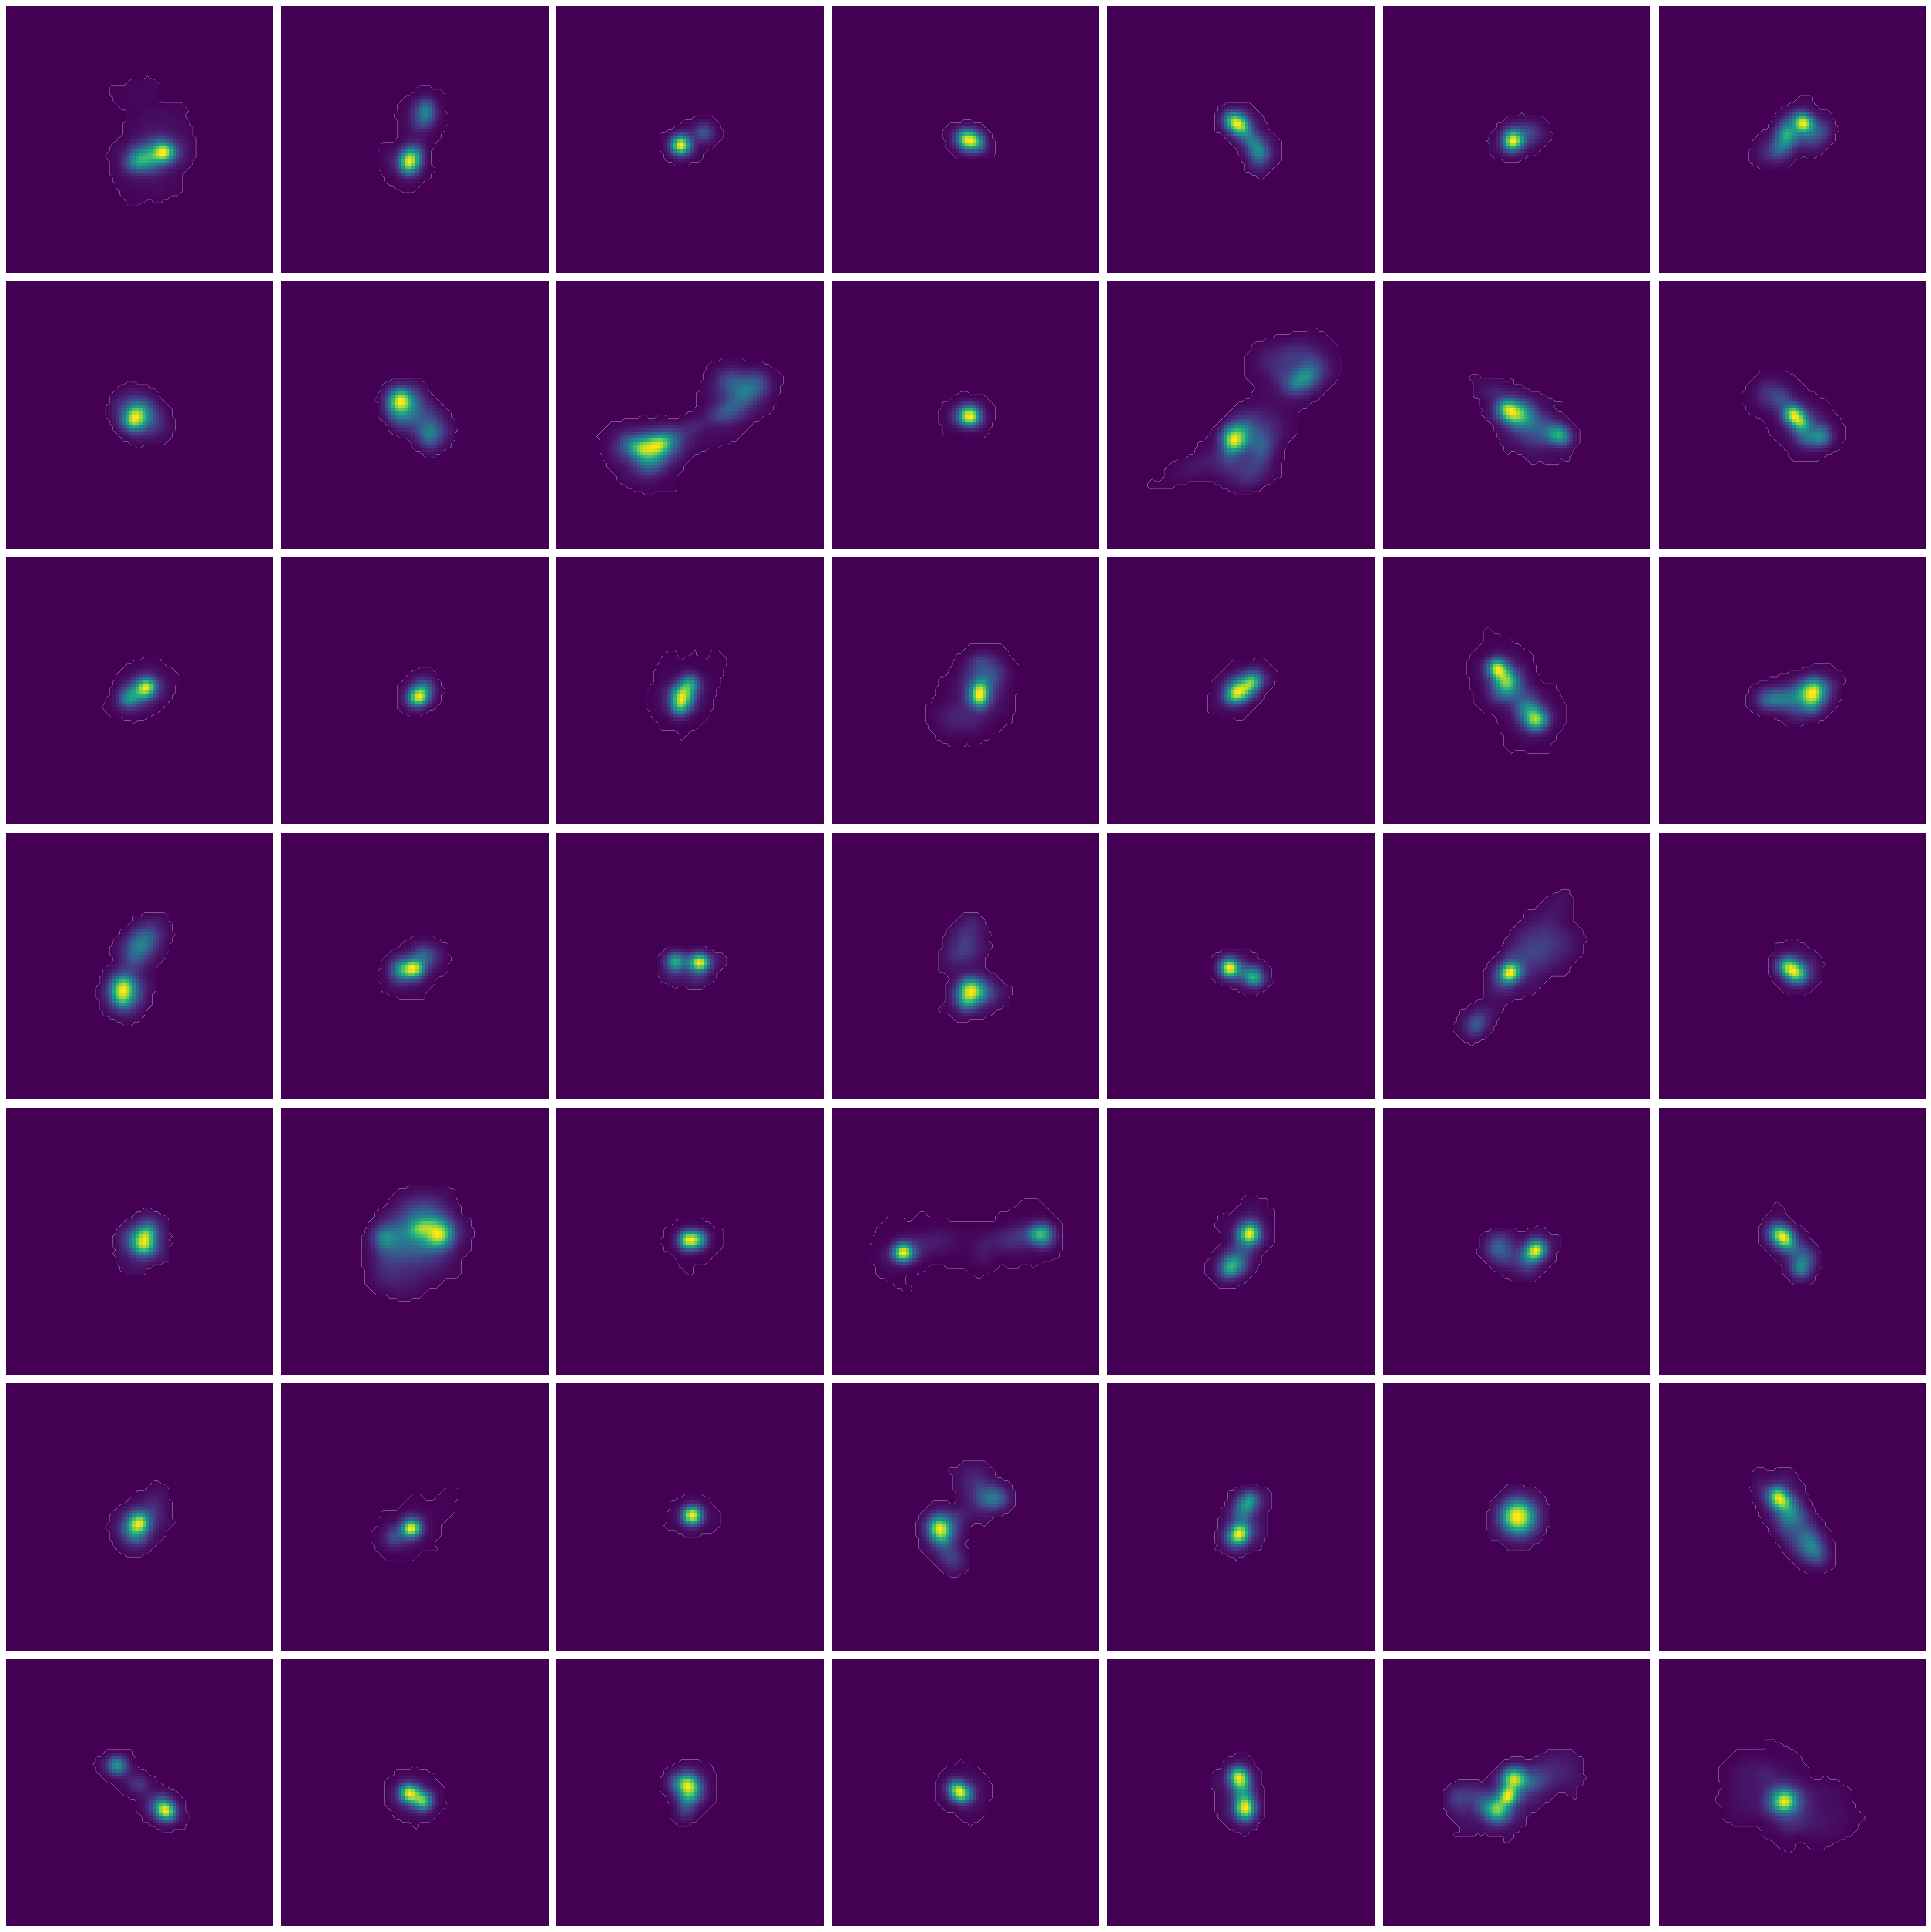

In [132]:
proto_dset.plot_image_grid(show_titles=False, n_imgs=49);

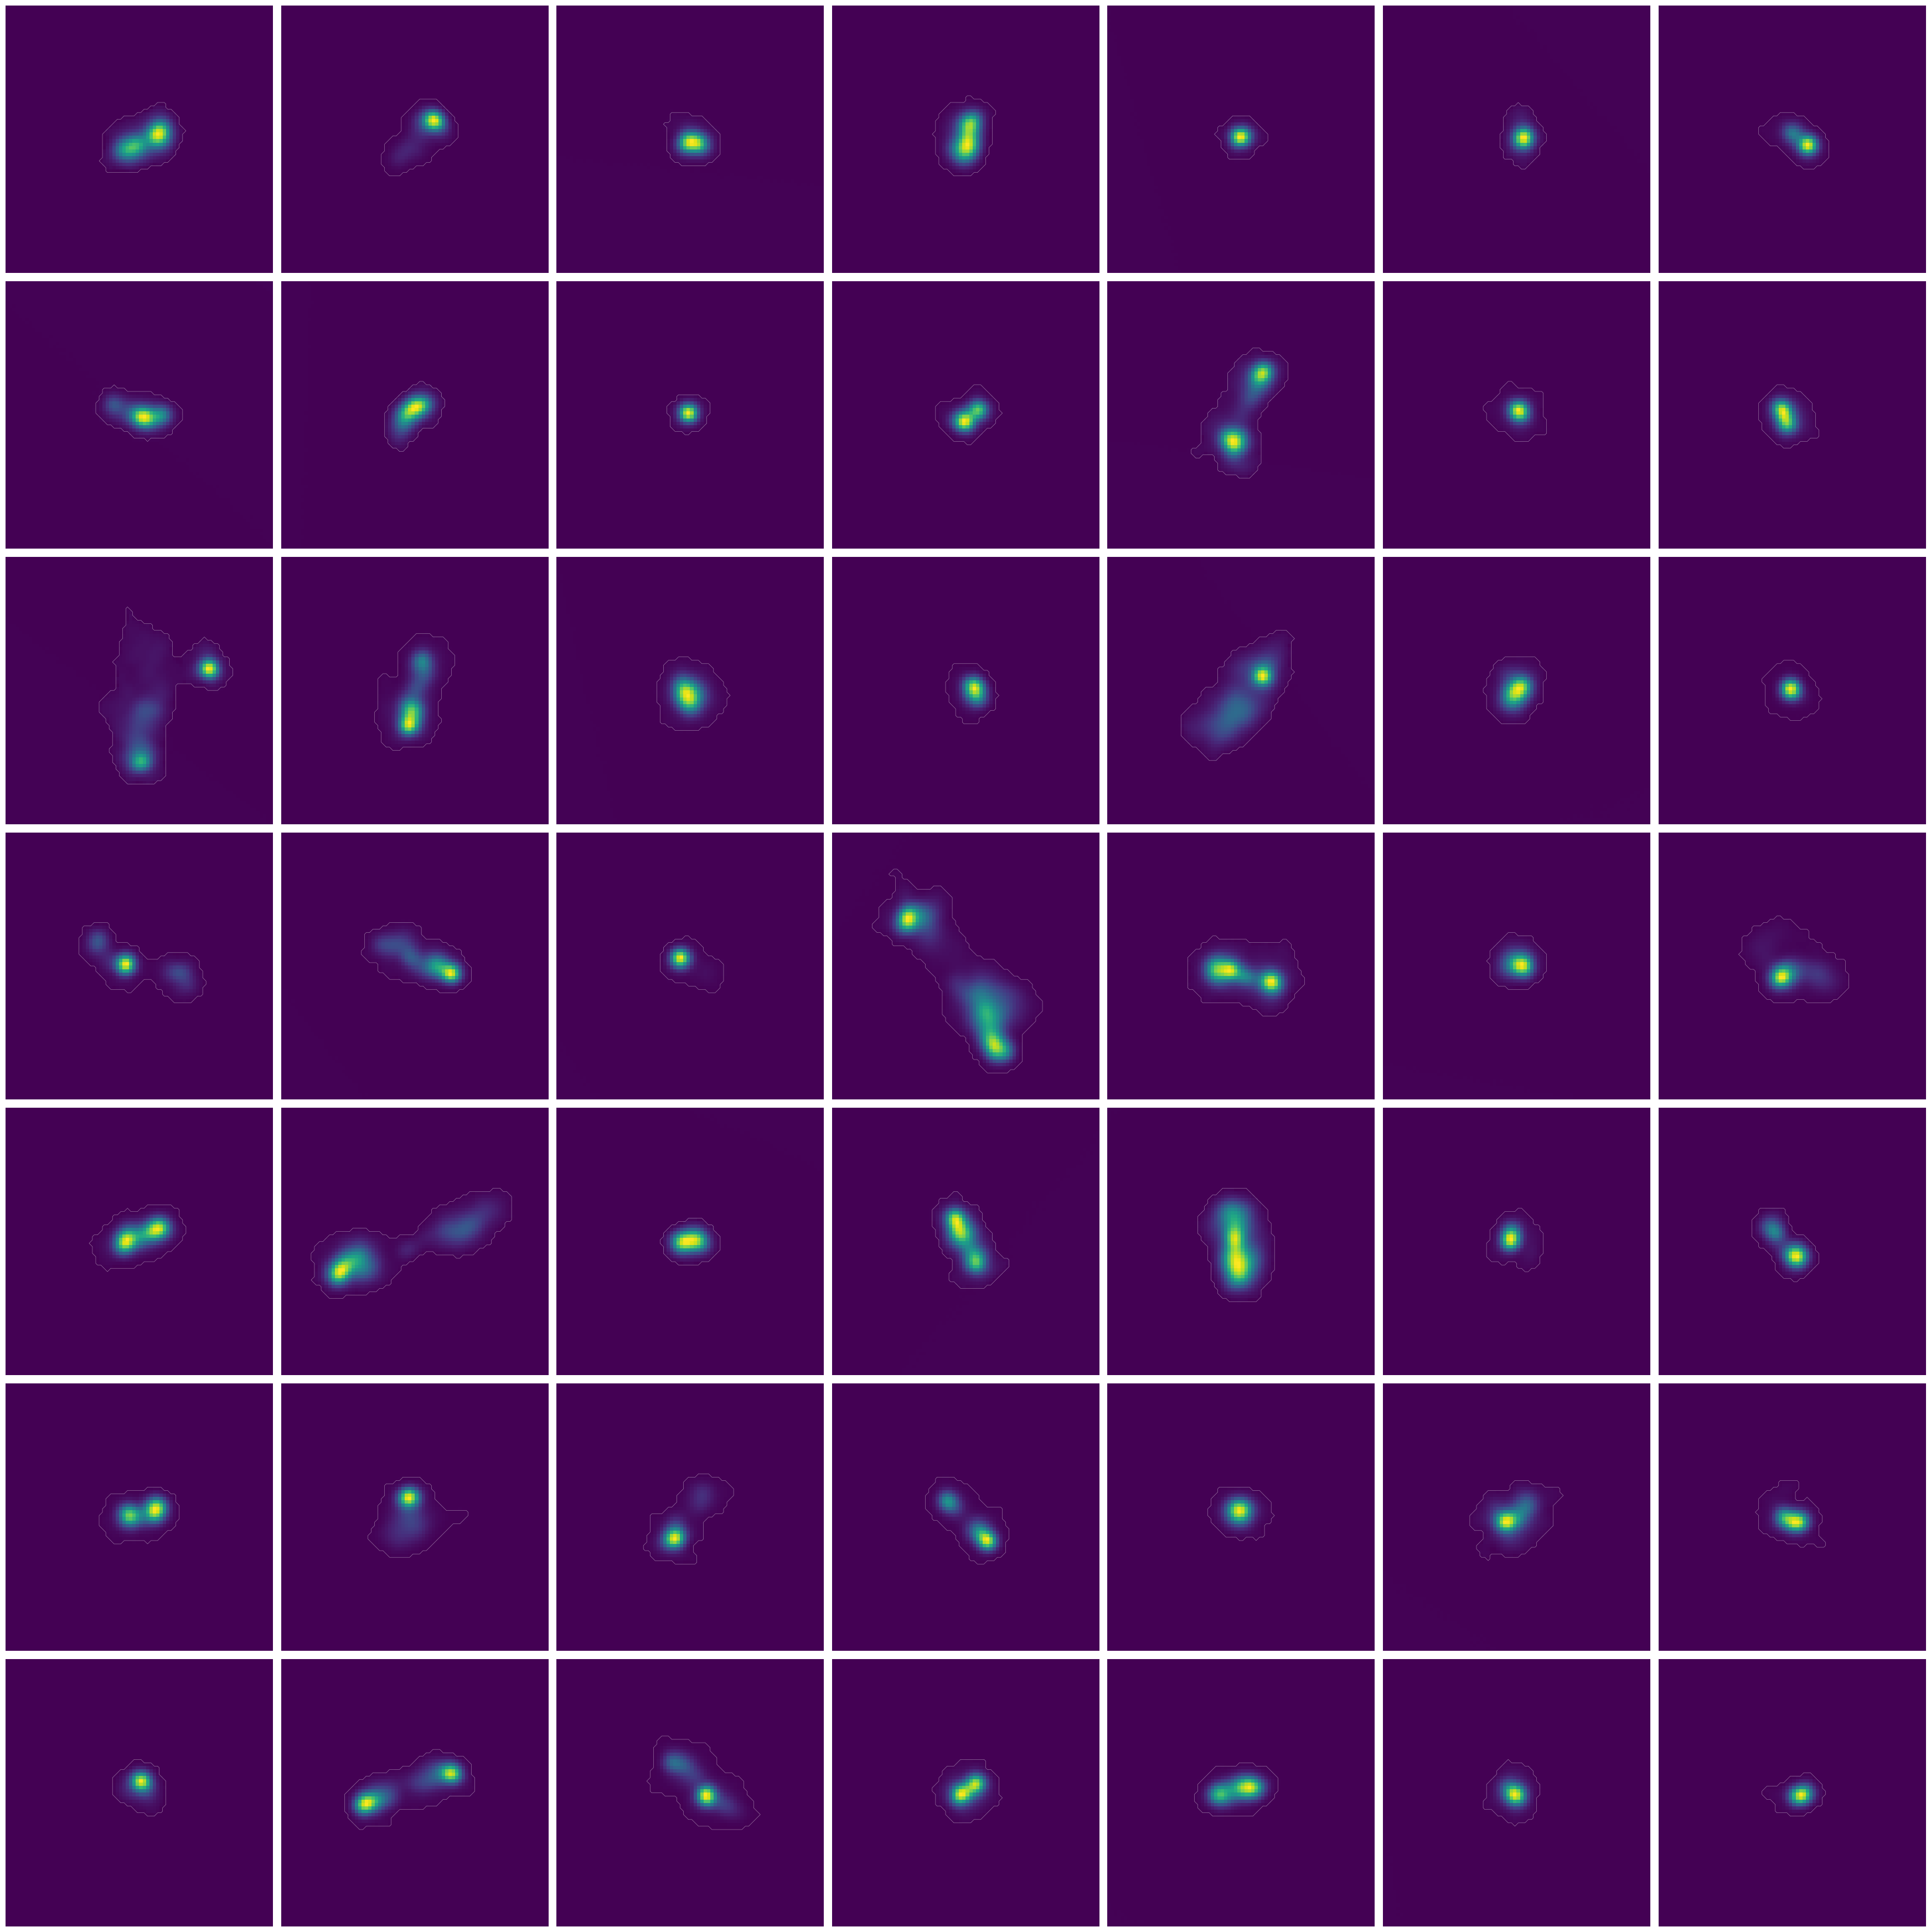

In [133]:
samples_dset.plot_image_grid(show_titles=False, n_imgs=49);

In [ ]:
def find_order(src_imgs, target_imgs):
    """
    Source images contains the target images in wrong order.
    """
    order = []
    for target_img in target_imgs:
        for i, src_img in enumerate(src_imgs):
            if np.all(src_img == target_img):
                order.append(i)
                break
    return order


order = find_order(data_cutouts, manual_cutouts)

In [ ]:
from data.datasets import CutoutsDataset

cutouts_file = Path(
    "/home/bbd0953/diffusion/image_data/LOFAR/cutouts/cutouts_200p_optC.hdf5"
)
cutouts = CutoutsDataset(cutouts_file, img_size=200)

In [ ]:
from data.cutouts import cutout_from_catalog

n = 10
ii = np.random.choice(len(cat), n, replace=False)

for i in ii:
    img = cutouts.data[i]
    manual_cutout, has_nan = cutout_from_catalog(cutouts.catalog, i, size_px=200)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(img)

    axs[1].imshow(manual_cutout)

    fig.suptitle(f"Index: {i}, has_nan: {has_nan}")

    for ax in axs:
        ax.axis("off")

    fig.show()

In [ ]:
# Find order of cutouts
mosaic_ids = cutouts.catalog["Mosaic_ID"].unique()

names_list = []
for mosaic in mosaic_ids:
    catalog_mosaic = cutouts.catalog[cutouts.catalog["Mosaic_ID"] == mosaic]
    names = catalog_mosaic["Source_Name"].values
    names_list += names.tolist()

In [ ]:
order = np.argsort(np.array(names_list))
order

In [ ]:
print(order.shape)
images_ordered = cutouts.data[order]
images_ordered.shape

In [ ]:
import h5py

with h5py.File(cutouts.path, "r+") as f:
    f["cutouts"][:] = images_ordered.numpy()

In [ ]:
from data.datasets import EvaluationDataset

dset = EvaluationDataset(
    paths.LOFAR_SUBSETS["200p"], img_size=200, selection="clean_mask_single_island"
)

In [ ]:
dset_cat = pd.read_hdf(dset.path, key="catalog")

with h5py.File(dset.path, "r") as f:
    sel_idxs = np.array(f["selections/clean_mask_single_island"])

dset_cat = dset_cat.iloc[sel_idxs]

In [ ]:
import numpy as np
from tqdm import tqdm

# Assuming dset_cat and cat are your DataFrames
subset_mask = cutouts.catalog["Source_Name"].isin(set(dset_cat["Source_Name"].values))

# Convert the result to a numpy array if needed
subset_mask = np.array(subset_mask)

In [ ]:
len(cutouts.catalog)

In [ ]:
subset_mask_ordered = subset_mask[order]
sub_cat_ordered = cutouts.catalog[subset_mask_ordered]

In [ ]:
original_sub_order = subset_mask * subset_mask.cumsum()
new_sub_order = original_sub_order[order]
sub_images_ordered = dset.data[new_sub_order[new_sub_order > 0] - 1]

In [ ]:
subset_order_idxs = new_sub_order[new_sub_order > 0] - 1

In [ ]:
with h5py.File(dset.path, "r+") as f:
    for key in f.keys():

        if key == "selections":
            for sub_key in f[key].keys():
                f[key][sub_key][:] = np.sort(f[key][sub_key])

        else:
            continue

In [ ]:
from data.cutouts import cutout_from_catalog

n = 10
ii = np.random.choice(len(dset), n, replace=False)

for i in ii:
    img = dset.data[i]
    manual_cutout, has_nan = cutout_from_catalog(dset_cat, i, size_px=200)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(img)

    axs[1].imshow(manual_cutout)

    fig.suptitle(f"Index: {i}, has_nan: {has_nan}")

    for ax in axs:
        ax.axis("off")

    fig.show()

In [ ]:
from data.datasets import EvaluationDataset

dset = EvaluationDataset(
    paths.LOFAR_SUBSETS["200p"],
    img_size=200,
    catalog_keys=["Mosaic_ID"],
    selection="clean_mask_single_island",
)
dset.masks = dset.masks_edge_thr

In [ ]:
import pandas as pd
import numpy as np

cat = pd.read_csv(paths.LOFAR_RES_CAT)


def read_separations(df, source_id):
    # Two series with same index
    col = df[source_id].drop(source_id)
    row = df.loc[source_id].drop(source_id)

    # Combine the two series
    comb = pd.concat([col[pd.notna(col)], row[pd.notna(row)]])
    return comb


def contaminating_sources(dset, idx):
    mosaic_id = dset.Mosaic_ID[idx]
    source_id = dset.names[idx]
    max_sep = 1.5 * dset.data.shape[-1] // 2 / 3600

    matches = []

    for coord in ["ra", "dec"]:
        df = pd.read_csv(
            paths.LOFAR_DATA_PARENT
            / f"source_separations/{mosaic_id}/source_delta_{coord}_{mosaic_id}.csv",
            index_col=0,
        )
        sep = read_separations(df, source_id)
        matches.append(sep[np.abs(sep.values) < max_sep].index.tolist())

    # Remove duplicates from output
    out = [src for src in matches[0] if src in matches[1]]
    return out


def get_coordinates(src_names, catalog=cat):
    out = []
    for name in src_names:
        src = catalog[catalog["Source_Name"] == name].iloc[0]
        if pd.notna(src["optRA"]):
            ra, dec = src["optRA"], src["optDec"]
        else:
            ra, dec = src["RA"], src["DEC"]
        out.append([ra, dec])
    return np.array(out)


def create_wcs(i, dset):
    center = get_coordinates([dset.names[i]])[0]
    cdelt = 1.5 / 3600
    wcs_params = {
        "CTYPE1": "RA---SIN",  # RA in TAN projection
        "CTYPE2": "DEC--SIN",  # Dec in TAN projection
        "CRVAL1": center[0],  # RA at reference pixel
        "CRVAL2": center[1],  # Dec at reference pixel
        "CUNIT1": "deg",
        "CUNIT2": "deg",
        "CRPIX1": 100,  # Reference pixel X (center of the image)
        "CRPIX2": 100,  # Reference pixel Y (center of the image)
        "CDELT1": -cdelt,  # Pixel scale in RA (degrees/pixel)
        "CDELT2": cdelt,  # Pixel scale in Dec (degrees/pixel)
        "RADESYS": "ICRS",
    }
    w = WCS(naxis=2)
    w.wcs.crpix = [wcs_params["CRPIX1"], wcs_params["CRPIX2"]]
    w.wcs.cdelt = np.array([wcs_params["CDELT1"], wcs_params["CDELT2"]])
    w.wcs.crval = [wcs_params["CRVAL1"], wcs_params["CRVAL2"]]
    w.wcs.ctype = [wcs_params["CTYPE1"], wcs_params["CTYPE2"]]
    w.wcs.radesys = wcs_params["RADESYS"]
    w.wcs.cunit = [wcs_params["CUNIT1"], wcs_params["CUNIT2"]]
    return w

In [ ]:
ii = np.random.choice(len(dset), 20, replace=False)

for i in ii:
    img = dset.data[i]
    mask = dset.masks[i]
    sources = contaminating_sources(dset, i)
    coords = get_coordinates(sources)
    center = get_coordinates([dset.names[i]])[0]
    wcs = create_wcs(i, dset)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={"projection": wcs})

    axs[0].imshow(img, origin="lower")
    axs[1].imshow(img * (1 - mask), origin="lower")

    for ax in axs:
        ax.contour(mask, levels=[0.5], colors="white", alpha=0.5)
        ax.scatter(
            center[0],
            center[1],
            transform=ax.get_transform("world"),
            s=30,
            color="orange",
            marker="x",
            alpha=0.5,
        )
        if len(coords) > 0:
            ax.scatter(
                coords[:, 0],
                coords[:, 1],
                transform=ax.get_transform("world"),
                s=30,
                color="red",
                marker="x",
                alpha=0.5,
            )

    fig.show()

In [ ]:
header

# Compress H5 File

In [ ]:
import h5py
import pandas as pd


def compress_hdf5_file(
    original_file_path, compressed_file_path, compression="gzip", compression_opts=9
):
    """
    Compress an existing HDF5 file using gzip compression.

    Args:
    - original_file_path (str): Path to the original HDF5 file.
    - compressed_file_path (str): Path where the compressed HDF5 file will be saved.
    - compression (str): Compression strategy. Default is 'gzip'.
    - compression_opts (int): Compression level. Default is 9 (highest).
    """
    with h5py.File(original_file_path, "r") as original_file:
        for dataset_name in original_file:

            if dataset_name == "catalog":
                data = pd.read_hdf(original_file_path, key=dataset_name)
                data.to_hdf(compressed_file_path, key=dataset_name, complevel=9)

            else:
                data = original_file[dataset_name]
                with h5py.File(compressed_file_path, "a") as compressed_file:
                    compressed_file.create_dataset(
                        dataset_name,
                        data=data,
                        compression=compression,
                        compression_opts=compression_opts,
                    )

            # Copy attributes if there are any
            with h5py.File(compressed_file_path, "a") as compressed_file:
                for attr_name in original_file[dataset_name].attrs:
                    compressed_file[dataset_name].attrs[attr_name] = original_file[
                        dataset_name
                    ].attrs[attr_name]

In [ ]:
import utils.paths as paths

f = paths.LOFAR_SUBSETS["0-clip"]

compress_hdf5_file(f, f.parent / (f.stem + "_compressed.h5"))

In [ ]:
with h5py.File(f, "r") as original_file:
    # Print keys
    print("Original file keys:")
    print(list(original_file.keys()))

# Images where pyBDSF fails

In [ ]:
import utils.paths as paths
import datasets.datasets as dsets

reload(dsets)

dset = dsets.EvaluationDataset("0-clip")

In [ ]:
dset.plot_image_grid()

In [ ]:
import analysis.bdsf_evaluation as bdsfeval

metrics = bdsfeval.get_metric_dict(dset.path)

In [ ]:
import numpy as np

area = metrics["q0.5_area"]
flag = area == 6400

idxs = np.where(flag)[0].flatten()
flag.sum(), idxs

In [ ]:
from plotting.image_plots import plot_image_grid

plot_image_grid(
    [dset[i] for i in idxs],
)

In [ ]:
plot_image_grid(
    [metrics["model_gaus_arr"][i] for i in idxs],
)

# Latent Space Interpolation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def slerp_step(t, v0, v1, DOT_THRESHOLD=0.9995):
    """helper function to spherically interpolate two arrays v1 v2"""

    inputs_are_torch = False
    if not isinstance(v0, np.ndarray):
        inputs_are_torch = True
        input_device = v0.device
        v0 = v0.cpu().numpy()
        v1 = v1.cpu().numpy()

    dot = np.sum(v0 * v1 / (np.linalg.norm(v0) * np.linalg.norm(v1)))
    if np.abs(dot) > DOT_THRESHOLD:
        v2 = (1 - t) * v0 + t * v1
    else:
        theta_0 = np.arccos(dot)
        sin_theta_0 = np.sin(theta_0)
        theta_t = theta_0 * t
        sin_theta_t = np.sin(theta_t)
        s0 = np.sin(theta_0 - theta_t) / sin_theta_0
        s1 = sin_theta_t / sin_theta_0
        v2 = s0 * v0 + s1 * v1

    if inputs_are_torch:
        v2 = torch.from_numpy(v2).to(input_device)

    return v2


def slerp(v0, v1, n_steps=10, DOT_THRESHOLD=0.9995):
    """Spherical linear interpolation between two arrays v1 v2"""
    steps = np.linspace(0, 1, n_steps)
    results = np.array([slerp_step(t, v0, v1) for t in steps])
    return results

In [ ]:
from model.init_utils import load_model_by_name
from utils.device_utils import distribute_model

model = load_model_by_name("Data_Augmented")
model, dev = distribute_model(model)

In [ ]:
n_curves = 9
curves = []
for i in range(n_curves):
    v0 = np.random.randn(80, 80)
    v1 = np.random.randn(80, 80)
    curve = slerp(v0, v1, n_steps=100)
    curves.append(curve)
curves = np.array(curves).reshape(-1, 80, 80)

import model.diffusion as diff

reload(diff)
import model.sample_utils as smpl

reload(smpl)

imgs = smpl.sample_batch(model, len(curves), latents=np.expand_dims(curves, 1))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import torch

# Number of images to be plotted on animation
side_length = 3
n_imgs = side_length**2

# frames should be of shape (n_imgs, n_frames, height, width)
frames = np.clip(imgs, -1, 1).reshape(n_imgs, -1, 80, 80)

# Create plot with n_imgs axes of quadratic shape, space for colorbars, no ticks
fig, axes = plt.subplots(
    side_length, side_length, figsize=(15, 15), tight_layout=True,
)
if n_imgs == 1:
    axes = np.array([[axes]])

fig.subplots_adjust(hspace=0.1, wspace=0.1, left=0.05, right=0.95)

for ax in axes.flatten():
    ax.axis("off")

# Helper function to get color limit of image
get_clim = lambda img: (img.min(), img.max())
    
# Plot first image to axes, return imshow objects in list
ims = []
for ax, img in zip(axes.flatten(), frames):
    min, max = get_clim(img[0])
    im = ax.imshow(img[0], vmin=min, vmax=max)
    ims.append(im)
    # plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.set_title(f"step={0}")

def animate(i):
    for im, img in zip(ims, frames):
        clim = get_clim(img[i])
        im.set_data(img[i])
        im.set_clim(*clim)
        im.axes.set_title(f"T={i}")
    return ims

%matplotlib inline
ani = animation.FuncAnimation(fig, animate, 
                              frames=frames.shape[1],
                              interval=100,
                              repeat_delay=2000,
                              blit=True);

plt.rcParams['animation.embed_limit'] = 2**128
# plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["animation.html"] = "jshtml"
# HTML(ani.to_jshtml())
ani

In [ ]:
import utils.paths as paths

out_folder = Path(paths.ANALYSIS_PARENT / "animations")

ani.save(out_folder / f"Latent_Space_Interpolation_2.mp4")

In [ ]:
n_col = 10
n_figs = len(curve) // n_col

for n in range(n_figs):

    fig, axs = plt.subplots(2, n_col, figsize=(20, 4), tight_layout=True)

    for i, (ax0, ax1) in enumerate(zip(axs[0], axs[1])):
        ax0.imshow(curve[i + n * n_col])
        ax0.axis("off")
        ax1.imshow(imgs[i + n * n_col].squeeze())
        ax1.axis("off")
    fig.show()

# Peak flux vs Residual

Load training data:

In [ ]:
from datasets.data_utils import EvaluationDataset
import utils.paths as paths

dset = EvaluationDataset(paths.LOFAR_SUBSETS["0-clip"], catalog_keys=["Sigma_SNR"])
dset.transform_max_vals()

Load bdsf stats:

In [ ]:
from analysis.bdsf_evaluation import load_bdsf_metric_dict

bdsf_metrics = load_bdsf_metric_dict(
    Path(
        "/hs/babbage/data/group-brueggen/tmartinez/diffusion/analysis_results/0-clip/bdsf/dicts"
    )
)

Calculate residuals:

In [ ]:
import numpy as np

model_gaus_arr = np.array([a.T for a in bdsf_metrics["model_gaus_arr"]])
img_arr = np.array([dset[i].squeeze().numpy() for i in range(len(dset))])
residuals = img_arr - model_gaus_arr

In [ ]:
import matplotlib.pyplot as plt
from skimage.measure import find_contours
from datasets.image_utils import sigma_mask
from analysis.bdsf_evaluation import quantile_values, quantile_area
from tqdm import tqdm


n = 10
idx = np.random.choice(len(img_arr), n, replace=False)

fig, axs = plt.subplots(4, n, figsize=(n * 3, 12), tight_layout=True)

for i, ax in tqdm(zip(idx, axs.T), total=n):
    img = img_arr[i]
    res = residuals[i]
    ax[0].imshow(img)
    ax[0].axis("off")
    ax[1].imshow(model_gaus_arr[i])
    ax[1].axis("off")
    ax[2].imshow(res, vmin=0, vmax=1)
    ax[2].axis("off")
    ax[3].imshow(res, cmap="bwr")
    ax[3].axis("off")

fig.show()

In [ ]:
res_sum = np.sum(np.clip(residuals, 0, None), axis=(1, 2))

In [ ]:
plt.scatter(dset.max_values_tr, res_sum, s=1, alpha=0.5)
plt.yscale("log")

In [ ]:
bdsf_metrics_gen = load_bdsf_metric_dict(
    Path(
        "/hs/babbage/data/group-brueggen/tmartinez/diffusion/analysis_results/Data_Augmented/bdsf/dicts"
    )
)

In [ ]:
samples = EvaluationDataset(
    Path(
        "/hs/babbage/data/group-brueggen/tmartinez/diffusion/analysis_results/Data_Augmented/Data_Augmented_samples_50000_guidance_strength=1.00e-01.pt"
    )
)

In [ ]:
context = np.load(
    "/hs/babbage/data/group-brueggen/tmartinez/diffusion/analysis_results/Data_Augmented/Data_Augmented_context_50000_guidance_strength=1.00e-01.npy"
)

In [ ]:
samples_arr = np.array([samples[i].squeeze().numpy() for i in range(len(samples))])
samples_model_arr = np.array([a.T for a in bdsf_metrics_gen["model_gaus_arr"]])
context_arr = np.array(context)
samples_residuals = samples_arr - samples_model_arr

In [ ]:
samples_res_sum = np.sum(np.clip(samples_residuals, 0, None), axis=(1, 2))

In [ ]:
mm = 1 / 25.4  # mm in inches
fig_width = 88 * mm
# plt.rcParams.update({"font.size": 5})
plt.style.use("seaborn-paper")
plt.rcParams.update(
    {
        "figure.constrained_layout.use": True,
        "figure.dpi": 300,
        "font.family": "Nimbus Roman",
        "font.size": 4.5,
        "mathtext.fontset": "custom",
        "mathtext.rm": "Nimbus Roman",
        "mathtext.it": "Nimbus Roman:italic",
        "mathtext.bf": "Nimbus Roman:bold",
        "mathtext.cal": "Nimbus Roman:italic",
        "text.usetex": False,
    }
)
out_path = Path("/home/bbd0953/diffusion/analysis_results/paper_plots")

In [ ]:
from matplotlib import colormaps as cm

s = 0.3
alpha = 0.3

colors = [cm["viridis"](i) for i in [0.2, 0.85]]

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width * 2 / 3))

ax.scatter(
    dset.max_values_tr,
    res_sum,
    s=s,
    alpha=alpha,
    label="LOFAR Dataset",
    color=colors[0],
)
ax.scatter(
    context_arr, samples_res_sum, s=s, alpha=alpha, label="Generated", color=colors[1]
)
ax.set_yscale("log")
ax.set_xlabel("$\hat{f}_\mathrm{scaled}$")
ax.set_ylabel("$\Delta_+$")

legend = ax.legend()
# Make legend handles more visible
# Modify the legend markers
for handle in legend.legendHandles:
    handle._sizes = [10]  # Change the marker size
    handle.set_alpha(1)  # Change the marker alpha

In [ ]:
from plotting.paper_plots import out_path

fig.savefig(out_path / "residual_vs_flux.pdf")

In [ ]:
bins = np.logspace(-1, 3)
plt.hist(res_sum, density=True, bins=bins, alpha=0.5)
plt.hist(samples_res_sum, bins=bins, density=True, alpha=0.5)
plt.xlabel("Residual Sum")
plt.ylabel("Count")
plt.yscale("log")
plt.xscale("log")
plt.show()

In [ ]:
res_mask = (res_sum > 10**2) & (res_sum < 10**3)

idxs = np.random.choice(np.where(res_mask)[0], 49, replace=False)

from plotting.image_plots import random_image_grid

random_image_grid(img_arr[idxs])

In [ ]:
samples_res_mask = (samples_res_sum > 10**2) & (samples_res_sum < 10**3)

idxs = np.random.choice(np.where(samples_res_mask)[0], 49, replace=False)

from plotting.image_plots import random_image_grid

random_image_grid(samples_arr[idxs])

# Image Similarity

In [ ]:
import numpy as np
import plotting.image_plots as pltimg

reload(pltimg)
from skimage.metrics import structural_similarity as ssim
from scipy.spatial import procrustes
from multiprocessing import Pool
from tqdm import tqdm
from sklearn.decomposition import PCA
from scipy.ndimage import rotate
from astropy.stats import sigma_clipped_stats
import plotting.paper_plots as pplt


def align_image(img):
    img = img.squeeze()
    _, _, sigma = sigma_clipped_stats(img)
    X = np.array(np.where(img.T > 0.1 + 5 * sigma)).T
    # Perform a PCA and compute the angle of the first principal axes
    pca = PCA(n_components=2).fit(X)
    angle_rad = np.arctan2(*pca.components_[0])
    angle_deg = (angle_rad / np.pi * 180) % 180
    # Rotate the image by the computed angle:
    rotated_img = rotate(img, -angle_deg - 90, reshape=False)
    return rotated_img, angle_deg


def plot_image(img):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(img.squeeze())
    ax.axis("off")
    fig.show()
    return fig, ax


def calculate_ssim(params):
    i_sample, i = params
    smpl = align_image(samples[i_sample].numpy().squeeze())[0]
    img = align_image(dset[i].numpy().squeeze())[0]
    return ssim(smpl, img, data_range=1)


def calculate_procrustes(params):
    i_sample, i = params
    smpl = align_image(samples[i_sample].numpy().squeeze())[0]
    img = align_image(dset[i].numpy().squeeze())[0]
    return procrustes(img, smpl)


def plot_match(i_sample, i_match, titles=True, **kwargs):
    img = align_image(samples[i_sample].numpy().squeeze())[0]

    if type(i_match) == int:
        i_match = [i_match]

    elif type(i_match) != list:
        i_match = i_match.tolist()

    imgs = [align_image(dset[i].numpy().squeeze())[0] for i in i_match]
    grid_kwargs = {
        "n_rows": 1,
    }
    grid_kwargs.update(kwargs)
    pltimg.plot_image_grid(
        [
            img,
        ]
        + imgs,
        titles=(
            [
                f"Sampled",
                "Real",
            ]
            if titles
            else [None, None]
        )
        + [None] * (len(i_match) - 1),
        **grid_kwargs,
    )


def get_plot_matches(i_samples, **kwargs):
    params = [(i_sample, i) for i_sample in i_samples for i in range(len(dset))]

    with Pool() as p:
        sim_results = list(tqdm(p.imap(calculate_ssim, params), total=len(params)))

    sim_results = np.array(sim_results).reshape(len(i_samples), len(dset))

    out = []
    for i_sample in range(len(i_samples)):
        i_match = np.argsort(sim_results[i_sample])[::-1][:5]
        out.append(i_match)
        print(f"Sample {i_sample} -- Matches: {i_match}")
        plot_match(i_samples[i_sample], i_match, **kwargs)
    return out

In [ ]:
import datasets.data_utils as dutil
import utils.paths as paths

dset = dutil.EvaluationDataset(paths.LOFAR_SUBSETS["0-clip"])

In [ ]:
reload(pltimg)
pltimg.random_image_grid(dset, n_img=25, idx_titles=True)

In [ ]:
samples_file = Path(
    "/hs/fs08/data/group-brueggen/tmartinez/diffusion/analysis_results/Data_Augmented/Data_Augmented_samples_50000_guidance_strength=1.00e-01.pt"
)
samples = dutil.EvaluationDataset(samples_file)

In [ ]:
ii = np.random.choice(len(samples), 49, replace=False)
imgs = [samples[i][0] for i in ii]

pltimg.plot_image_grid(imgs, titles=ii)

In [ ]:
i_samples = [
    4773,
    3266,
    18768,
    43202,
    37992,
    48925,
    3319,
    22958,
    19399,
    22253,
    17524,
    33308,
    30687,
    33727,
]

matches = get_plot_matches(i_samples, fig_axs=fig_axs)

In [ ]:
i_samples_new = [
    37979,
    21157,
    17524,
    33308,
    30687,
    33727,
    1205,
]
matches += get_plot_matches(i_samples_new)

In [ ]:
n_figs = 2
n_rows = len(i_samples) // n_figs
figs = []
for i_fig in range(n_figs):
    fig, axs = plt.subplots(
        n_rows,
        6,
        figsize=(pplt.fig_width * 2, pplt.fig_width * n_rows * 1 / 3),
        constrained_layout=False,
        gridspec_kw={
            "hspace": 0.01,
            "wspace": 0.01,
            "left": 0.01,
            "right": 0.99,
            "top": 0.99,
            "bottom": 0.01,
        },
    )

    # Get the current position of the left-most subplot
    for i in range(n_rows):
        ax = axs[i]
        plot_match(
            i_samples[i + n_rows * i_fig],
            matches[i + n_rows * i_fig],
            fig_axs=(fig, ax),
            titles=(i == 0),
        )
        pos = ax[0].get_position()
        # Calculate the new x0 position by subtracting a small value (e.g., 0.01) from the current x0
        new_x0 = (
            pos.x0 - 0.02
        )  # Adjust the 0.01 as needed to move the subplot to the left
        # Set the new position for the subplot
        new_pos = [
            new_x0,
            pos.y0,
            pos.width,
            pos.height,
        ]  # Keep the original width and height
        ax[0].set_position(new_pos)
    figs.append(fig)

In [ ]:
for i, fig in enumerate(figs):
    fig.savefig(pplt.out_path / f"nearest_neoighbors_{i}.pdf")

In [ ]:
fig, axs = plt.subplots(5, 10, figsize=(16, 8))
for ax, ax2, i, img in zip(axs.flatten()[::2], axs.flatten()[1::2], ii, imgs):
    _, _, sigma = sigma_clipped_stats(img.squeeze())
    ax.imshow(img.squeeze())
    ax.axis("off")
    ax.scatter(*np.where(img.T > 0.1 + 5 * sigma), s=0.25, alpha=0.3, color="red")
    ax.set_title(i)
    img_aligned, angle = align_image(img)
    ax2.imshow(align_image(img)[0])
    ax2.set_title(f"{angle:.2f}")
    ax2.axis("off")
    fig.show()

In [ ]:
i = 45758
plot_image(samples[i])
plot_image(align_image(samples[i])[0])

# Source Region Definition

In [ ]:
from datasets.data_utils import EvaluationDataset
import utils.paths as paths

dset = EvaluationDataset(paths.LOFAR_SUBSETS["0-clip"], catalog_keys=["Sigma_SNR"])

In [ ]:
import matplotlib.pyplot as plt

dset.transform_max_vals()

plt.hist(dset.max_values_tr)

In [ ]:
from skimage.measure import label, regionprops, find_contours
from astropy.stats import sigma_clipped_stats


def remove_small_islands(mask, min_pixels):
    # Label the islands in the mask
    labels = label(mask)

    # Create a new mask of the same shape as the original mask, filled with False
    new_mask = np.zeros(mask.shape, dtype=bool)

    # For each region (island) in the labeled mask
    for region in regionprops(labels):
        # If the region has at least min_pixels
        if region.area >= min_pixels:
            # Set the pixels in the new mask that correspond to this region to True
            new_mask[labels == region.label] = True

    return new_mask


def plot_contours(mask, ax, color):
    # Find the contours of the mask
    contours = find_contours(mask, 0.5)
    # Plot each contour
    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0], color=color)


def expand_islands(mask1, mask2):
    # Label the islands in the masks
    labels1 = label(mask1)
    labels2 = label(mask2)

    # Create a new mask of the same shape as the original masks, filled with False
    new_mask = np.copy(mask1)

    # For each region (island) in the labeled first mask
    for region in regionprops(labels1):
        region_mask = labels1 == region.label
        overlapping_labels = np.unique(labels2[region_mask * mask2])
        if len(overlapping_labels) > 0:
            overlap_mask = np.isin(labels2, overlapping_labels)
            new_mask[overlap_mask] = True

    return new_mask


def sigma_mask_expand(
    img,
    px_threshold,
    isl_threshold,
    min_pixels,
):
    _, med, std = sigma_clipped_stats(img)

    # Pixel threshold mask
    mask = img > med + px_threshold * std

    # Remove islands smaller than min_pixels
    mask = remove_small_islands(mask, min_pixels)

    # Less restrictive island mask
    isl_mask = img > med + isl_threshold * std
    # isl_mask = img > quantile_values(img, [0.8])[0]

    # Find overlapping islands
    expanded_mask = expand_islands(mask, isl_mask)

    return expanded_mask, mask, isl_mask


def quantile_mask_expand(img, q, size_thr=0.1, Q_thr=0.5):
    q_vals = quantile_values(img, q)

    # Pixel threshold mask
    mask = img > q_vals[0]

    isl_mask = img > q_vals[1]

    expanded_mask = expand_islands(mask, isl_mask)

    # Include islands from isl_mask whose sizes exceed size_thr * image size
    labels = label(isl_mask)
    for region in regionprops(labels):
        Q = 4 * np.pi * region.area / region.perimeter**2
        if region.area >= size_thr * img.size and Q > Q_thr:
            expanded_mask[labels == region.label] = True

    return expanded_mask, mask, isl_mask

In [ ]:
import matplotlib.pyplot as plt
from skimage.measure import find_contours
from datasets.image_utils import sigma_mask
from analysis.bdsf_evaluation import quantile_values, quantile_area
from tqdm import tqdm

# Pick some images with max_values_tr smaller than -2.5
n = 25
idx = np.where(dset.max_values_tr < -1)[0]
np.random.seed(2)
idx = idx[np.random.choice(len(idx), n, replace=False)]

fig, axs = plt.subplots(*(int(n ** (1 / 2)),) * 2, figsize=(15, 15), tight_layout=True)

for i, ax in tqdm(zip(idx, axs.flatten()), total=n):
    img = dset[i].squeeze().numpy()
    ax.imshow(img)
    ax.axis("off")

    # Mask with pixels above threshold
    masks = quantile_mask_expand(img, [0.1, 0.9], size_thr=0.01, Q_thr=0.1)
    plot_contours(masks[0], ax, "green")

    for mask, color in zip(reversed(masks), ["red", "blue", "green"]):

        plot_contours(mask, ax, color)

fig.show()

In [ ]:
from multiprocessing import Pool
from tqdm.notebook import tqdm


# Plot transformed max val vs std-dev in image outside mask
def background_std_size(i):
    img = dset[i].squeeze().numpy()
    mask = quantile_mask_expand(img, [0.1, 0.9], 0.1)[0]
    return np.std(img[~mask]), np.sum(mask)


# Create a pool of worker processes
with Pool() as p:
    stds_sizes = np.array(
        list(tqdm(p.imap(background_std_size, range(len(dset))), total=len(dset)))
    )

print("Done")

In [ ]:
stds, sizes = stds_sizes.T

plt.scatter(dset.max_values_tr, stds, s=0.2, alpha=0.1)
plt.yscale("log")
# plt.xscale('log')

In [ ]:
pltimg.metric_peek(
    stds,
    np.logspace(-3, -1, 11),
    images=dset.data,
)

In [ ]:
idxs = np.argwhere(stds > 0.07)

fig, axs = plt.subplots(6, 7, figsize=(15, 15), tight_layout=True)

for i, ax in tqdm(zip(idxs, axs.flatten()), total=len(idxs)):
    img = dset[i].squeeze().numpy()
    ax.imshow(img)

    # Mask with pixels above threshold
    masks = quantile_mask_expand(img, [0.1, 0.9], size_thr=0.1, Q_thr=0.1)
    plot_contours(masks[0], ax, "green")

    for mask, color in zip(reversed(masks), ["red", "blue", "green"]):

        plot_contours(mask, ax, color)


for ax in axs.flatten():
    ax.axis("off")

fig.show()

# Monitor File Sizes

In [ ]:
from pathlib import Path
import pandas as pd

import datetime


def get_mtime(t):
    return datetime.datetime.fromtimestamp(t, tz=datetime.timezone.utc)


def get_size(p, size_in="GB", include_symlinks=False, recursive=True):
    match size_in:
        case "GB":
            inv_unit = 1e-9
        case "MB":
            inv_unit = 1e-6
        case "KB":
            inv_unit = 1e-3
        case _:
            raise ValueError(f"Invalid size_in: {size_in}")

    if p.is_symlink() and not include_symlinks:
        return 0

    if p.is_file():
        return p.stat().st_size * inv_unit

    elif not recursive:
        return 0

    else:
        try:
            return sum(get_size(child, size_in=size_in) for child in p.iterdir())

        except PermissionError as p:
            print(f"PermissionError: {p}")
            return 0

        except NotADirectoryError as n:
            print(f"NotADirectoryError: {n}")
            return 0


def path_info_df(p, size_in="GB", include_symlinks=False, recursive=True):
    files = []
    for p in p.iterdir():
        try:
            if not p.is_symlink() or include_symlinks:
                files.append(p)
        except PermissionError:
            continue

    path_info = {
        "name": [f.name for f in files],
        "type": [f.suffix if f.is_file() else "folder" for f in files],
        f"size ({size_in})": [
            round(
                get_size(
                    f,
                    size_in=size_in,
                    include_symlinks=include_symlinks,
                    recursive=recursive,
                ),
                1,
            )
            for f in files
        ],
        "date": [get_mtime(f.stat().st_mtime) for f in files],
        "owner": [f.owner() for f in files],
    }
    df = pd.DataFrame(path_info)
    mask = df["owner"] == "bbd0953"  # & (df['size'] > 5000)
    df_large = df[mask].sort_values(by=f"size ({size_in})", ascending=False)
    return df_large

In [ ]:
import utils.paths as paths

p = paths.STORAGE_PARENT / "image_data/LOFAR/subsets"
df = path_info_df(p, size_in="GB", include_symlinks=False, recursive=True)
df

In [ ]:
names = [
    n for n, o in zip(df["name"], df["owner"]) if ("sweep" in n) and o == "bbd0953"
]
names

In [ ]:
import shutil

for n in names:
    # Remove the file
    # (p / n).unlink()
    shutil.rmtree(p / n)

In [ ]:
p = Path("/home/bbd0953/diffusion")
include_symlinks = False
files = [p for p in p.iterdir() if not p.is_symlink() or include_symlinks]
files

In [ ]:
p = Path("/home/bbd0953/diffusion/.cenv/lib/python3.11")
path_info_df(
    p,
    include_symlinks=False,
)

In [ ]:
p = Path("/tmp")
df = path_info_df(p, include_symlinks=True, recursive=True, size_in="MB")

mask = ["process_cutouts" in name for name in df["name"]]

df[mask]

In [ ]:
Path("/tmp/pymp-2g34w01z/listener-q8vlx_0j").is_fifo()